# Visualising the performance of using prior elicitation

In [1]:
import os
import json
import tqdm
from pathlib import Path
import textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
import seaborn as sns

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.utils import load_nested_dict_to_pandas

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
RESULTS_PATH = Path(os.path.join("results", "elicitation"))
PRIORS_DIR = Path(os.path.join("priors", "elicitation"))

In [4]:
def load_result_dicts(path: Path):
    results_files = [
        f for f in os.listdir(path) 
        if (f.endswith(".json") and f.startswith("prior_no_prior"))
    ]
    print(f"Loading {len(results_files)} files from {path}")
    results_dicts = [
        json.load(open(os.path.join(path, f), "r"))
        for f in results_files
    ]

    return results_files, results_dicts

In [5]:
def result_dicts_to_df(results_files, results_dicts):
    results_dfs = [
        load_nested_dict_to_pandas(
            results_dict, level_names=["dataset", "run", "n_data_points_seen", "prior_type"]
        ).assign(results_file_name=results_file_name)
        
        for results_dict, results_file_name in zip(results_dicts, results_files)
    ]

    results_df = pd.concat(
        results_dfs
    ).astype(
        {
            "n_data_points_seen": int,
        }
    )

    return results_df

In [6]:
# results directory for each model
model_results_dir_dict = {
    "informative": "gpt-3-5-turbo-0125",
    "uninformative": "uninformative",
    "gpt_4_turbo_prior": "gpt-4-turbo-2024-04-09",
    "deepseek_32b_q4": "deepseek-r1-32b-int4",
}

results_df = pd.DataFrame()

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    # loading the results from the dictionaries to a dataframe
    model_results_df = (
        result_dicts_to_df(
            # loading the files to dictionaries
            *load_result_dicts(RESULTS_PATH.joinpath(model_results_dir))
        )
    ).assign(
        prior_type=model_name
    )

    results_df = pd.concat(
        [
            results_df,
            model_results_df
        ]
    )

Loading results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading 80 files from results/elicitation/gpt-3-5-turbo-0125


Loading results:  25%|██▌       | 1/4 [00:02<00:08,  2.79s/it]

Loading 80 files from results/elicitation/uninformative


Loading results:  50%|█████     | 2/4 [00:05<00:05,  2.96s/it]

Loading 80 files from results/elicitation/gpt-4-turbo-2024-04-09


Loading results:  75%|███████▌  | 3/4 [00:09<00:03,  3.15s/it]

Loading 60 files from results/elicitation/deepseek-r1-32b-int4


Loading results: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


In [7]:
dataset_metric_to_plot = {
    "fake_data": "mse",
    "uti": "accuracy",
    "breast_cancer": "accuracy",
    "california_housing": "mse",
    "heart_disease": "accuracy",
    "wine_quality": "accuracy",
    "diabetes": "mse",
    "hypothyroid": "accuracy",

}
dataset_rename = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}


In [8]:
accuracy_results = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .assign(sample=lambda x: x["metrics_to_plot"].apply(lambda x: np.arange(len(x))))
    .explode(["metrics_to_plot", "sample"])
    .set_index("sample", append=True)
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
)
accuracy_results

,dataset,n_data_points_seen,prior_type,run,sample,metrics_to_plot
0,UTI,2,informative,9,0,0.533679
1,UTI,2,informative,9,1,0.569948
2,UTI,2,informative,9,2,0.564767
3,UTI,2,informative,9,3,0.492228
4,UTI,2,informative,9,4,0.471503
...,...,...,...,...,...,...
52499995,Hypothyroid,50,deepseek_32b_q4,8,24995,0.933333
52499996,Hypothyroid,50,deepseek_32b_q4,8,24996,0.893333
52499997,Hypothyroid,50,deepseek_32b_q4,8,24997,0.893333
52499998,Hypothyroid,50,deepseek_32b_q4,8,24998,0.946667


In [9]:
dataset_metric_to_plot = {
    "uti": "average_auc",
    "breast_cancer": "average_auc",
    "california_housing": "mse",
    "fake_data": "mse",
    "heart_disease": "average_auc",
    "wine_quality": "average_auc",
    "diabetes": "mse",
    "hypothyroid": "average_auc",
}

dataset_rename = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}


auc_results = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .assign(sample=lambda x: x["metrics_to_plot"].apply(lambda x: np.arange(len(x))))
    .explode(["metrics_to_plot", "sample"])
    .set_index("sample", append=True)
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
)
auc_results

,dataset,n_data_points_seen,prior_type,run,sample,metrics_to_plot
0,UTI,2,informative,9,0,0.615836
1,UTI,5,informative,9,0,0.781671
2,UTI,10,informative,9,0,0.740431
3,UTI,20,informative,9,0,0.761725
4,UTI,30,informative,9,0,0.772642
...,...,...,...,...,...,...
19251325,Hypothyroid,10,deepseek_32b_q4,8,0,0.972973
19251326,Hypothyroid,20,deepseek_32b_q4,8,0,0.995733
19251327,Hypothyroid,30,deepseek_32b_q4,8,0,0.98293
19251328,Hypothyroid,40,deepseek_32b_q4,8,0,0.992176


In [10]:
accuracy_results_hist = (
    accuracy_results
    .loc[
        lambda df: df["n_data_points_seen"].isin([2, 5, 10, 25, 50])
    ]
)

## Histograms

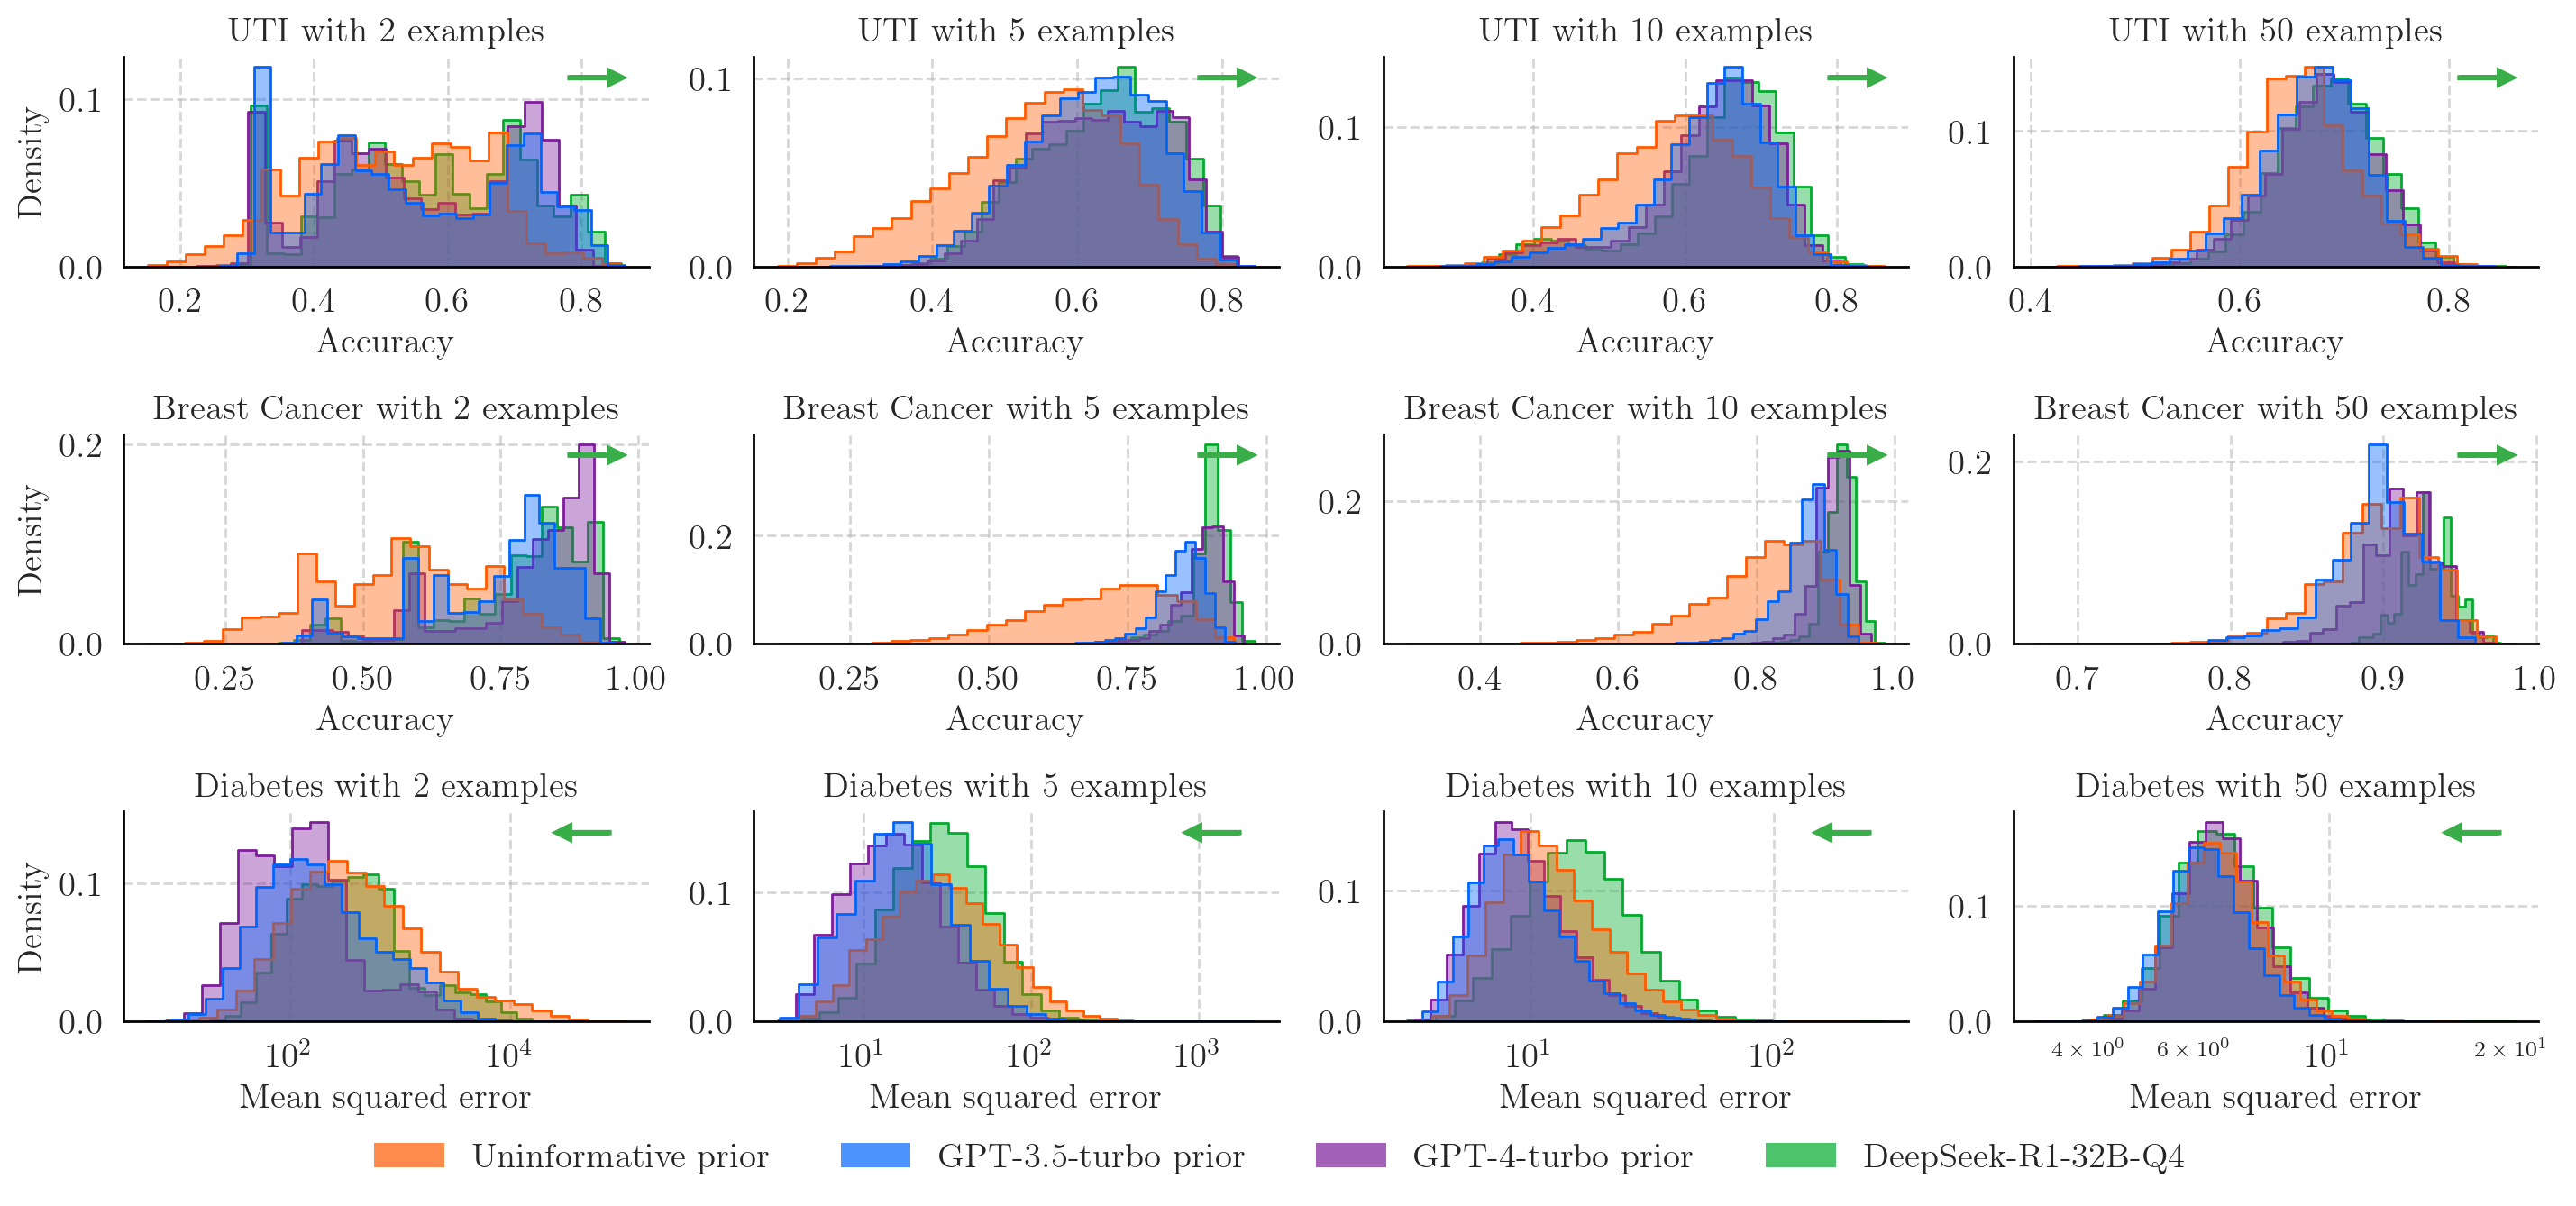

In [ ]:
fontsize = 14

def wrap(string, max_width):
    return '\n'.join(textwrap.wrap(string,max_width))

dataset_order = [
    "UTI",
    "Breast Cancer",
    "Diabetes"
    #"California Housing",
]

dataset_metric_to_plot = {
    r"$y = 2 x_1 - x_2 + x_3$": "mean squared error",
    "UTI": "accuracy",
    "Breast Cancer": "accuracy",
    "Heart Disease": "accuracy",
    "Diabetes": "mean squared error",
    "Hypothyroid": "accuracy",
    #"Wine Quality": "accuracy",
    #"California Housing": "mean squared error",

}

accuracy_results_hist_to_plot = accuracy_results_hist.query("dataset in @dataset_order")

plot_idx = {
    (dataset, n_data_points_seen): (i, j)
    for i, dataset in enumerate(dataset_order)
    for j, n_data_points_seen in enumerate(
        np.sort(accuracy_results_hist_to_plot['n_data_points_seen'].unique())
    )
}


plt.close()

with graph_theme():
    n_cols = accuracy_results_hist_to_plot['n_data_points_seen'].nunique()
    n_rows = accuracy_results_hist_to_plot['dataset'].nunique()

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(2*linewidth, 0.6*2.5*linewidth/1.618)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for nax, ((dataset, n_data_points_seen), plotting_df) in enumerate(
        accuracy_results_hist_to_plot.groupby(["dataset", "n_data_points_seen"], sort=True)
    ):
        

        row, col = plot_idx[(dataset, n_data_points_seen)]

        ax = axes[row, col]

        ax=sns.histplot(
            data=plotting_df,
            x="metrics_to_plot",
            hue="prior_type",
            hue_order=["informative", "uninformative", "gpt_4_turbo_prior", "deepseek_32b_q4"],
            palette={
                "uninformative":"xkcd:bright orange", 
                "informative":"xkcd:bright blue",
                "gpt_4_turbo_prior":"xkcd:purple",
                "deepseek_32b_q4":"xkcd:kelly green",
            },
            element="step",
            alpha=0.4,
            bins=25,
            #edgecolor="black",
            linewidth=1.0,
            stat='probability',
            common_bins=False,
            common_norm=False,
            ax=ax,
            log_scale=False if dataset_metric_to_plot[dataset] != "mean squared error" else True,
            legend=False,
        )

        ax.set_title(
            wrap(
                f"{dataset} "
                f"with {n_data_points_seen} examples",
                35
            ), 
            fontsize=fontsize
        )
        ax.tick_params(axis="both", labelsize=fontsize)

        if col == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
        else:
            ax.set_ylabel("", fontsize=fontsize)

        ax.set_xlabel(
            dataset_metric_to_plot[dataset].capitalize(),
            fontsize=fontsize
        )

        x = 0.85 if dataset_metric_to_plot[dataset] != "mean squared error" else 0.925
        dx = 0.075 if dataset_metric_to_plot[dataset] != "mean squared error" else -0.075
        ax.arrow(
            x=x, y=0.9, 
            dx=dx, dy=0.0,
            head_width=0.05*1.25, head_length=0.025,
            color='xkcd:medium green',
            alpha=1.0,
            linewidth=2,
            transform=ax.transAxes
        )

    leg = fig.legend(
        loc="center",
        labels=[
            r"Uninformative prior", 
            "GPT-3.5-turbo prior",
            "GPT-4-turbo prior",
            "DeepSeek-R1-32B-Q4",
        ], 
        handles=[
            mpatches.Patch(
                facecolor="xkcd:bright orange", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:bright blue", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:purple", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:kelly green", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.025),
        ncols=4,
        frameon=False,
    )

    fig.subplots_adjust(
        hspace=0.8,
        wspace=0.2,
        top=0.95,
        bottom=0.14,
        left=0.05,
        right=0.99,
    )

    fig.savefig("results/elicitation_results_grid.pdf")
    fig.savefig("results/elicitation_results_grid.svg")

    plt.show()

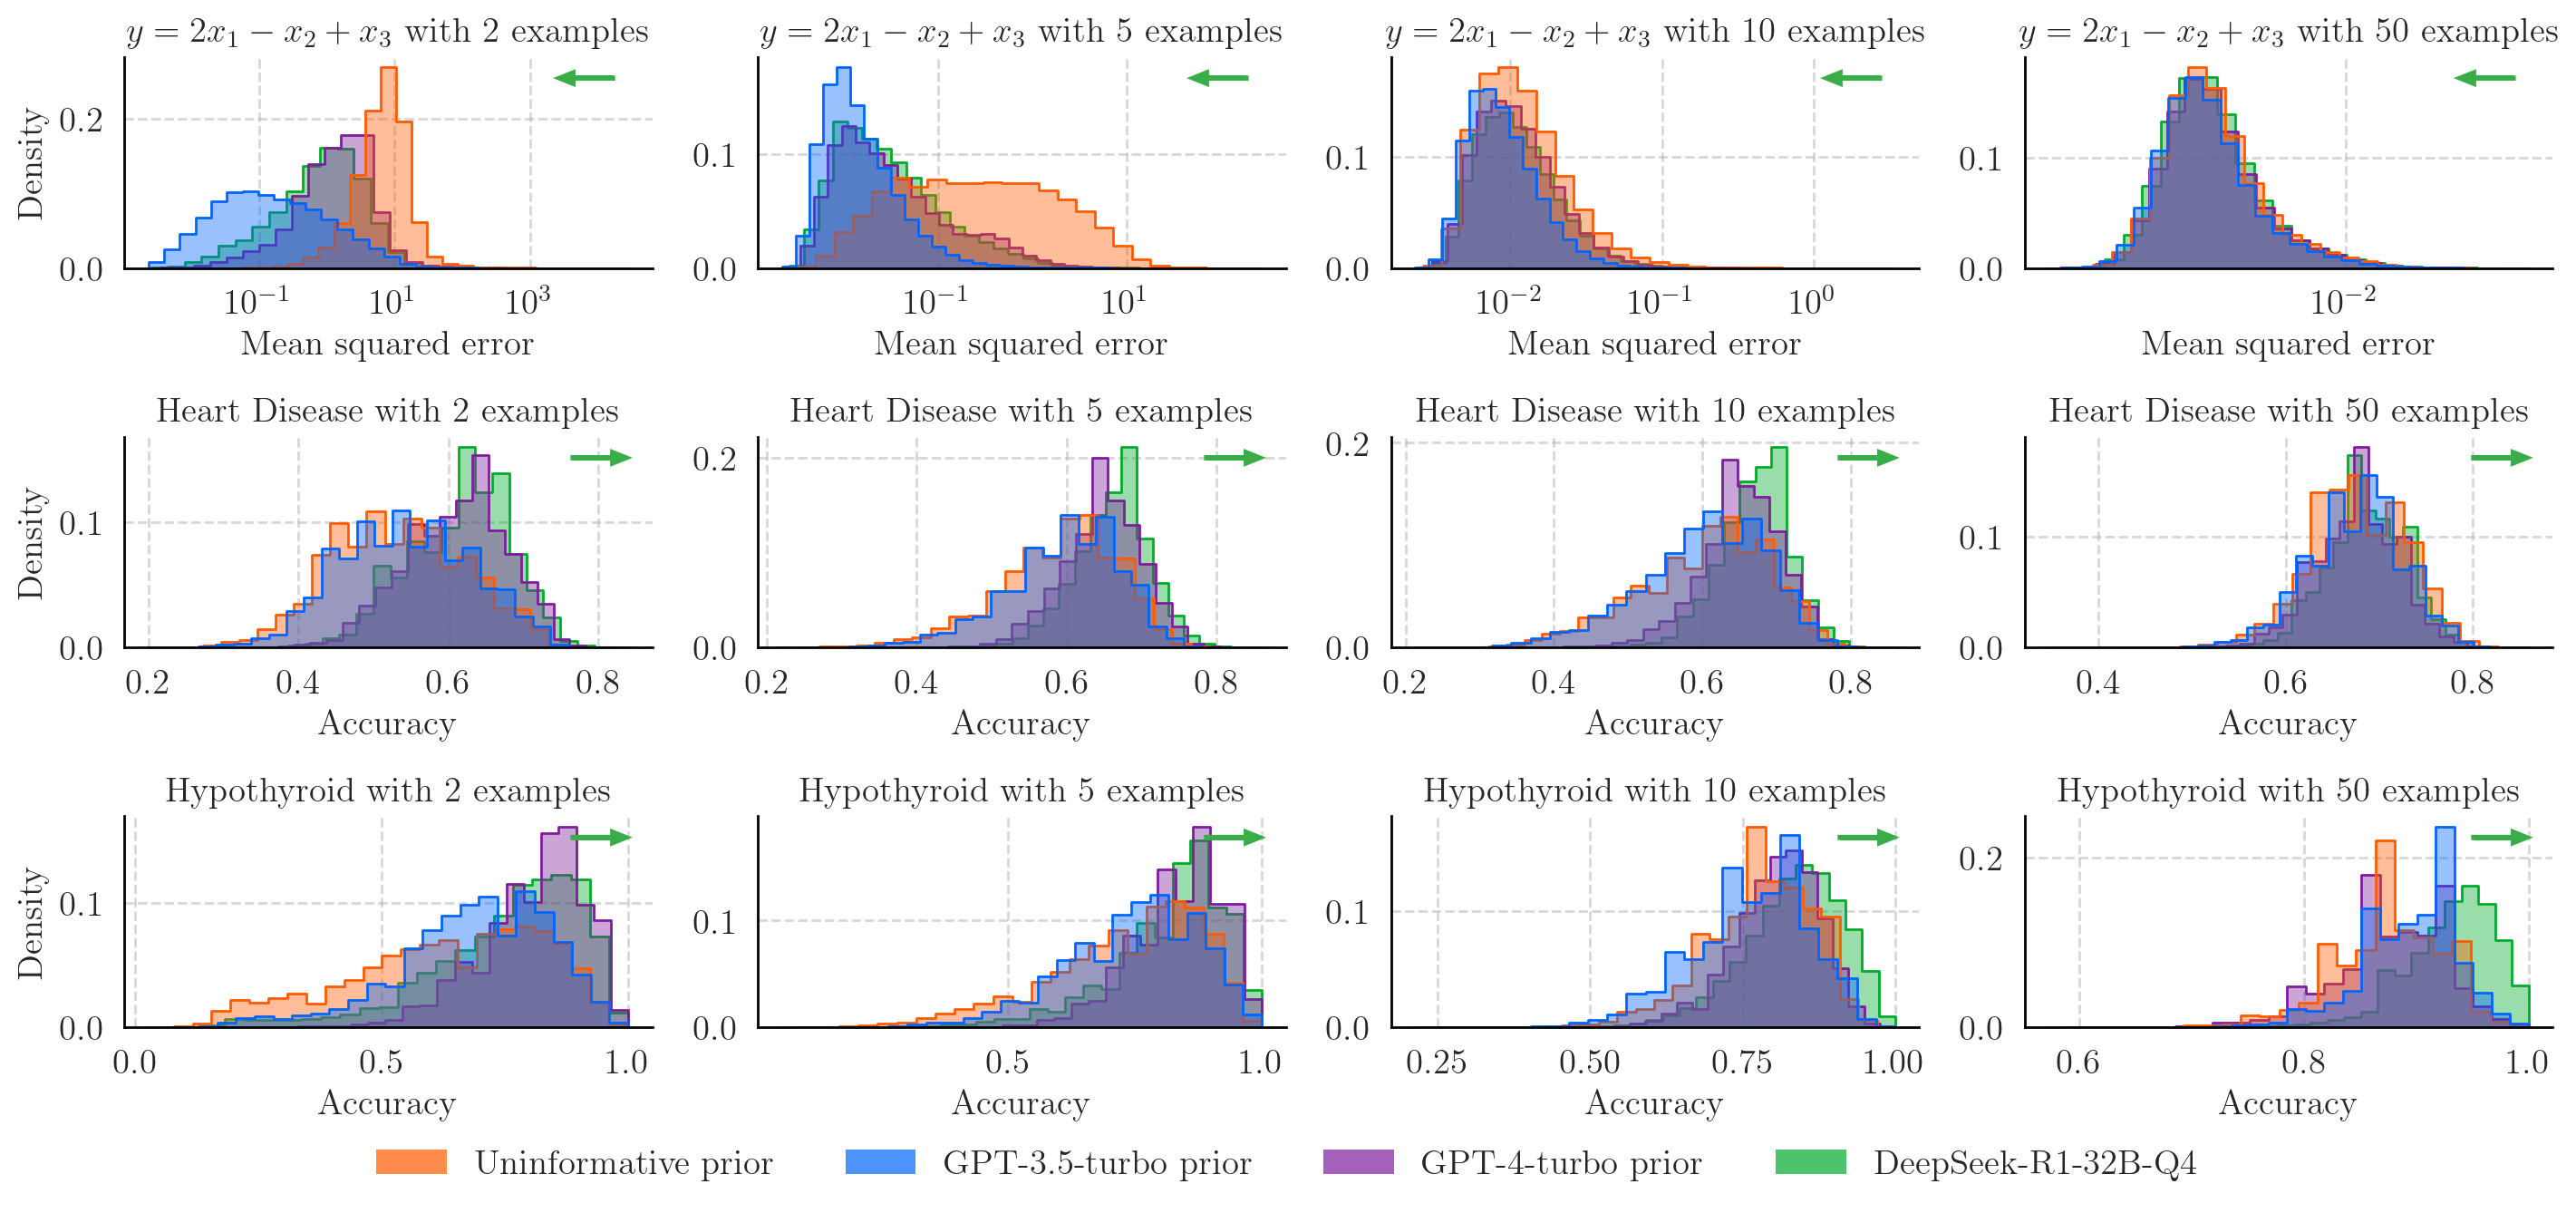

In [13]:
fontsize = 14

def wrap(string, max_width):
    return '\n'.join(textwrap.wrap(string,max_width))

dataset_order = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "Heart Disease",
    "Hypothyroid",
    #"Wine Quality",
]

dataset_metric_to_plot = {
    r"$y = 2 x_1 - x_2 + x_3$": "mean squared error",
    "UTI": "accuracy",
    "Breast Cancer": "accuracy",
    "Heart Disease": "accuracy",
    "Diabetes": "mean squared error",
    "Hypothyroid": "accuracy",
    # "Wine Quality": "accuracy",
    # "California Housing": "mean squared error",
}

accuracy_results_hist_to_plot = accuracy_results_hist.query("dataset in @dataset_order")

plot_idx = {
    (dataset, n_data_points_seen): (i, j)
    for i, dataset in enumerate(dataset_order)
    for j, n_data_points_seen in enumerate(
        np.sort(accuracy_results_hist_to_plot['n_data_points_seen'].unique())
    )
}


plt.close()

with graph_theme():
    n_cols = accuracy_results_hist_to_plot['n_data_points_seen'].nunique()
    n_rows = accuracy_results_hist_to_plot['dataset'].nunique()

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(2*linewidth, 0.6*2.5*linewidth/1.618)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for nax, ((dataset, n_data_points_seen), plotting_df) in enumerate(
        accuracy_results_hist_to_plot.groupby(["dataset", "n_data_points_seen"], sort=True)
    ):
        

        row, col = plot_idx[(dataset, n_data_points_seen)]

        ax = axes[row, col]

        ax=sns.histplot(
            data=plotting_df,
            x="metrics_to_plot",
            hue="prior_type",
            hue_order=["informative", "uninformative", "gpt_4_turbo_prior", "deepseek_32b_q4"],
            palette={
                "uninformative":"xkcd:bright orange", 
                "informative":"xkcd:bright blue",
                "gpt_4_turbo_prior":"xkcd:purple",
                "deepseek_32b_q4":"xkcd:kelly green",
            },
            element="step",
            alpha=0.4,
            bins=25,
            #edgecolor="black",
            linewidth=1.0,
            stat='probability',
            common_bins=False,
            common_norm=False,
            ax=ax,
            log_scale=(
                False 
                if dataset_metric_to_plot[dataset] != "mean squared error" 
                else True
            ),
            legend=False,
        )

        ax.set_title(
            wrap(
                f"{dataset} "
                f"with {n_data_points_seen} examples",
                50
            ), 
            fontsize=fontsize
        )
        ax.tick_params(axis="both", labelsize=fontsize)

        if col == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
        else:
            ax.set_ylabel("", fontsize=fontsize)

        ax.set_xlabel(
            dataset_metric_to_plot[dataset].capitalize(),
            fontsize=fontsize
        )

        x = (
            0.85 if dataset_metric_to_plot[dataset] != "mean squared error" 
            else 0.925
        )
        dx = (
            0.075 
            if dataset_metric_to_plot[dataset] != "mean squared error"
            else -0.075
        )
        ax.arrow(
            x=x, y=0.9, 
            dx=dx, dy=0.0,
            head_width=0.05, head_length=0.025,
            color='xkcd:medium green',
            alpha=1.0,
            linewidth=2,
            transform=ax.transAxes
        )

    leg = fig.legend(
        loc="center",
        labels=[
            r"Uninformative prior", 
            "GPT-3.5-turbo prior",
            "GPT-4-turbo prior",
            "DeepSeek-R1-32B-Q4",
        ], 
        handles=[
            mpatches.Patch(
                facecolor="xkcd:bright orange", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:bright blue", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:purple", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:kelly green", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.025),
        ncols=4,
        frameon=False,
    )

    fig.subplots_adjust(
        hspace=0.8,
        wspace=0.2,
        top=0.95,
        bottom=0.14,
        left=0.05,
        right=0.99,
    )


    fig.savefig("results/elicitation_results_grid_other.pdf")

    plt.show()

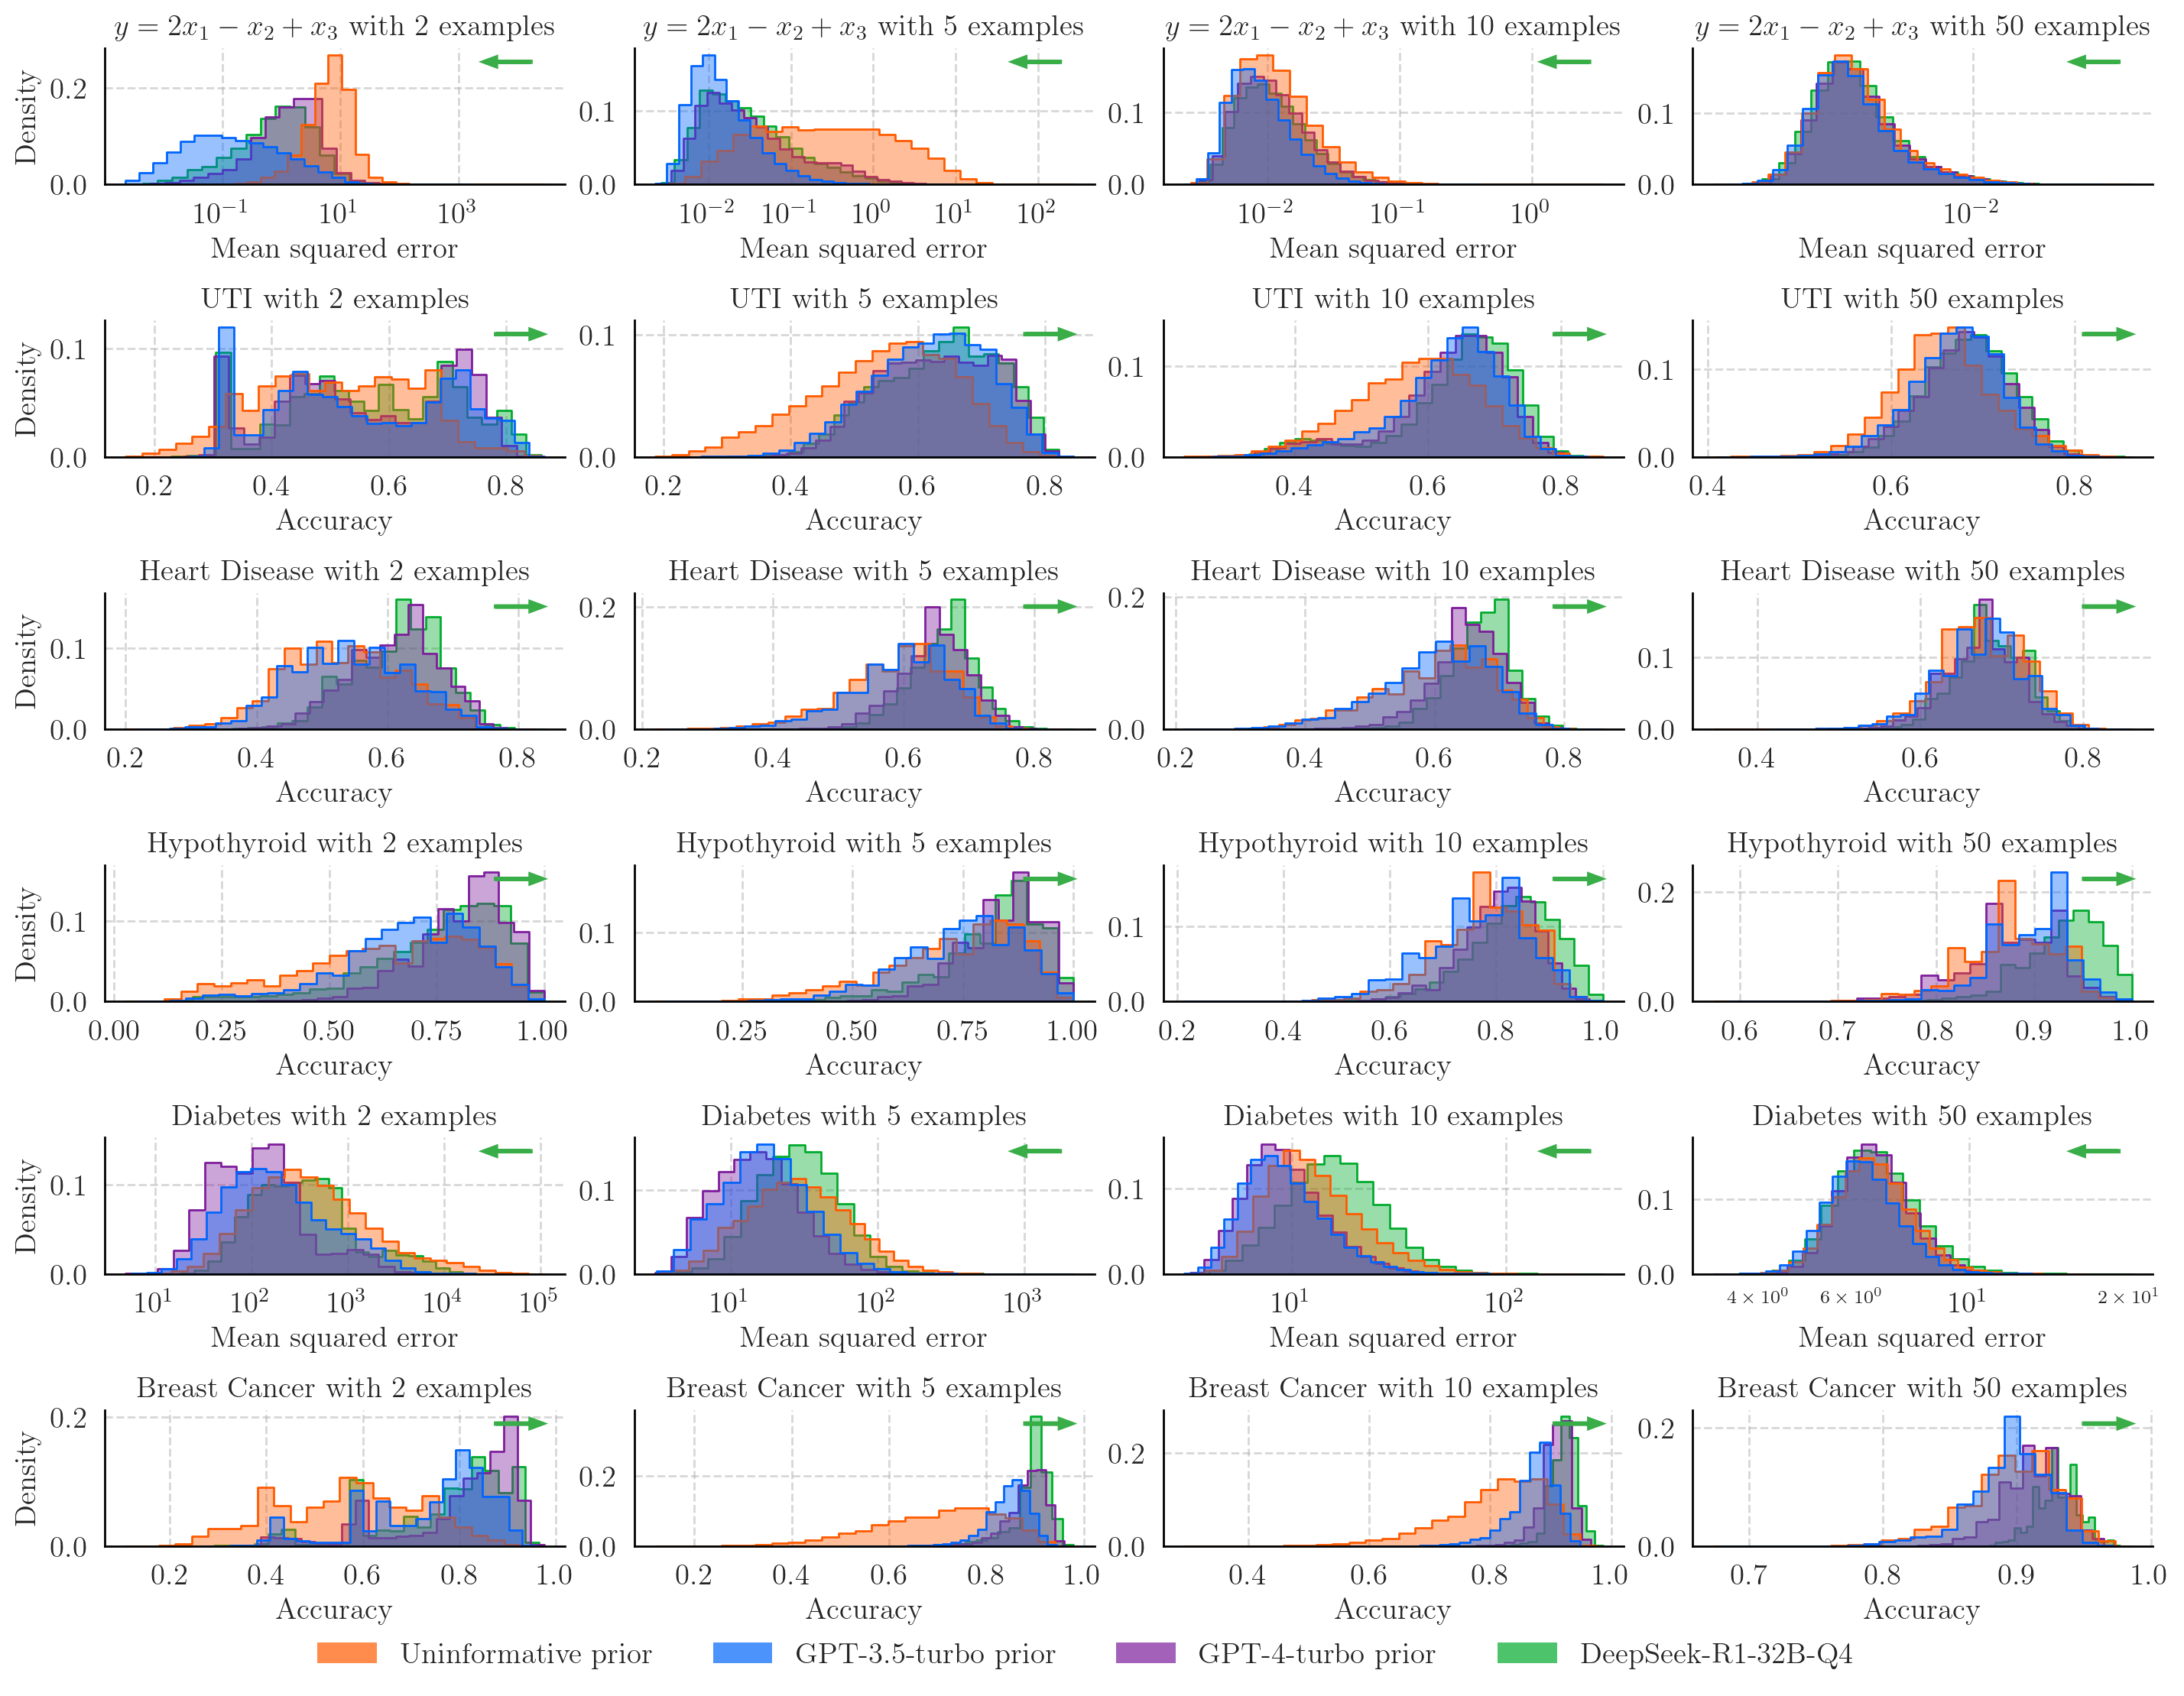

In [14]:
fontsize = 14

def wrap(string, max_width):
    return '\n'.join(textwrap.wrap(string,max_width))

dataset_order = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Heart Disease",
    "Hypothyroid",
    "Diabetes",
    "Breast Cancer",
    #"California Housing",
    #"Wine Quality",
]

dataset_metric_to_plot = {
    r"$y = 2 x_1 - x_2 + x_3$": "mean squared error",
    "UTI": "accuracy",
    "Breast Cancer": "accuracy",
    "Heart Disease": "accuracy",
    "Diabetes": "mean squared error",
    "Hypothyroid": "accuracy",
    #"Wine Quality": "accuracy",
    #"California Housing": "mean squared error",
}

accuracy_results_hist_to_plot = accuracy_results_hist.query("dataset in @dataset_order")

plot_idx = {
    (dataset, n_data_points_seen): (i, j)
    for i, dataset in enumerate(dataset_order)
    for j, n_data_points_seen in enumerate(
        np.sort(accuracy_results_hist_to_plot['n_data_points_seen'].unique())
    )
}


plt.close()

with graph_theme():
    n_cols = accuracy_results_hist_to_plot['n_data_points_seen'].nunique()
    n_rows = accuracy_results_hist_to_plot['dataset'].nunique()

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(2*linewidth, 2.5*linewidth/1.618)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for nax, ((dataset, n_data_points_seen), plotting_df) in enumerate(
        accuracy_results_hist_to_plot.groupby(["dataset", "n_data_points_seen"], sort=True)
    ):
        

        row, col = plot_idx[(dataset, n_data_points_seen)]

        ax = axes[row, col]

        ax=sns.histplot(
            data=plotting_df,
            x="metrics_to_plot",
            hue="prior_type",
            hue_order=["informative", "uninformative", "gpt_4_turbo_prior", "deepseek_32b_q4"],
            palette={
                "uninformative":"xkcd:bright orange", 
                "informative":"xkcd:bright blue",
                "gpt_4_turbo_prior":"xkcd:purple",
                "deepseek_32b_q4":"xkcd:kelly green",
            },
            element="step",
            alpha=0.4,
            bins=25,
            #edgecolor="black",
            linewidth=1.0,
            stat='probability',
            common_bins=False,
            common_norm=False,
            ax=ax,
            log_scale=False if dataset_metric_to_plot[dataset] != "mean squared error" else True,
            legend=False,
        )

        ax.set_title(
            wrap(
                f"{dataset} "
                f"with {n_data_points_seen} examples",
                50
            ), 
            fontsize=fontsize
        )
        ax.tick_params(axis="both", labelsize=fontsize)

        if col == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
        else:
            ax.set_ylabel("", fontsize=fontsize)

        ax.set_xlabel(
            dataset_metric_to_plot[dataset].capitalize(),
            fontsize=fontsize
        )

        x = 0.85 if dataset_metric_to_plot[dataset] != "mean squared error" else 0.925
        dx = 0.075 if dataset_metric_to_plot[dataset] != "mean squared error" else -0.075
        ax.arrow(
            x=x, y=0.9, 
            dx=dx, dy=0.0,
            head_width=0.05*1.25, head_length=0.025,
            color='xkcd:medium green',
            alpha=1.0,
            linewidth=2,
            transform=ax.transAxes
        )

    leg = fig.legend(
        loc="center",
        labels=[
            r"Uninformative prior", 
            "GPT-3.5-turbo prior",
            "GPT-4-turbo prior",
            "DeepSeek-R1-32B-Q4",
        ], 
        handles=[
            mpatches.Patch(
                facecolor="xkcd:bright orange", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:bright blue", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:purple", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:kelly green", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.02),
        ncols=4,
        frameon=False,
    )

    fig.subplots_adjust(
        hspace=1.0,
        wspace=0.15,
        top=0.975,
        bottom=0.085,
        left=0.05,
        right=0.99,
    )

    fig.savefig("results/elicitation_results_grid_full.pdf")
    fig.savefig("results/elicitation_results_grid_full.svg")

    plt.show()

## Line plot

In [11]:
accuracy_results_line_plot = (
    accuracy_results
    .loc[lambda df: df["n_data_points_seen"].isin([5, 10, 20, 25, 30, 40, 50])]
    .groupby(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .mean()
    .reset_index()
)

also load the gpt4 results:

In [12]:
# results directory for each model
model_results_dir_dict = {
    "gpt_4_turbo_prior": "gpt-4-turbo-2024-04-09",
    "deepseek_32b_q4": "deepseek-r1-32b-int4",
}

results_df_gpt4 = pd.DataFrame()

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    results_df_gpt4 = pd.concat(
        [
            results_df_gpt4,
            # loading the results from the dictionaries to a dataframe
            result_dicts_to_df(
                # loading the files to dictionaries
                *load_result_dicts(RESULTS_PATH.joinpath(model_results_dir))
            ).replace(
                # adding the model name
                {"prior_type": {"informative": model_name}}
            )
        ]
    )

Loading results:   0%|          | 0/2 [00:00<?, ?it/s]

Loading 80 files from results/elicitation/gpt-4-turbo-2024-04-09


Loading results:  50%|█████     | 1/2 [00:02<00:02,  2.93s/it]

Loading 60 files from results/elicitation/deepseek-r1-32b-int4


Loading results: 100%|██████████| 2/2 [00:04<00:00,  2.50s/it]


In [13]:
results_df_gpt4

,dataset,run,n_data_points_seen,prior_type,accuracy,average_accuracy,average_auc,results_file_name,mse,average_mse
0,uti,9,2,gpt_4_turbo_prior,"[[0.44041450777202074, 0.43005181347150256, 0....",0.478217,0.629111,prior_no_prior_results_uti_9.json,NaN,NaN
0,uti,9,5,gpt_4_turbo_prior,"[[0.7409326424870466, 0.6994818652849741, 0.63...",0.669638,0.774528,prior_no_prior_results_uti_9.json,NaN,NaN
0,uti,9,10,gpt_4_turbo_prior,"[[0.6373056994818653, 0.6994818652849741, 0.67...",0.685355,0.717049,prior_no_prior_results_uti_9.json,NaN,NaN
0,uti,9,20,gpt_4_turbo_prior,"[[0.6839378238341969, 0.6994818652849741, 0.70...",0.679145,0.722911,prior_no_prior_results_uti_9.json,NaN,NaN
0,uti,9,30,gpt_4_turbo_prior,"[[0.7046632124352331, 0.694300518134715, 0.689...",0.704064,0.762668,prior_no_prior_results_uti_9.json,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
0,hypothyroid,8,10,deepseek_32b_q4,"[[0.8666666666666667, 0.8, 0.8, 0.773333333333...",0.799383,0.972973,prior_no_prior_results_hypothyroid_8.json,NaN,NaN
0,hypothyroid,8,20,deepseek_32b_q4,"[[0.84, 0.9333333333333333, 0.9333333333333333...",0.877892,0.995733,prior_no_prior_results_hypothyroid_8.json,NaN,NaN
0,hypothyroid,8,30,deepseek_32b_q4,"[[0.8266666666666667, 0.72, 0.84, 0.8, 0.93333...",0.875347,0.982930,prior_no_prior_results_hypothyroid_8.json,NaN,NaN
0,hypothyroid,8,40,deepseek_32b_q4,"[[0.96, 0.76, 0.8, 0.8533333333333334, 0.92, 0...",0.906733,0.992176,prior_no_prior_results_hypothyroid_8.json,NaN,NaN


In [14]:
dataset_metric_to_plot = {
    "fake_data": "mse",
    "uti": "accuracy",
    "breast_cancer": "accuracy",
    "california_housing": "mse",
    "heart_disease": "accuracy",
    "wine_quality": "accuracy",
    "diabetes": "mse",
    "hypothyroid": "accuracy",

}
dataset_rename = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}

accuracy_results_gpt4 = (
    results_df_gpt4
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .assign(metrics_to_plot=lambda df: df["metrics_to_plot"].apply(np.mean))
    .reset_index()
    .replace({"dataset": dataset_rename})
    .loc[lambda df: df["n_data_points_seen"].isin([5, 10, 20, 25, 30, 40, 50])]
)
accuracy_results_gpt4

,dataset,n_data_points_seen,prior_type,run,metrics_to_plot
1,UTI,5,gpt_4_turbo_prior,9,0.669638
2,UTI,10,gpt_4_turbo_prior,9,0.685355
3,UTI,20,gpt_4_turbo_prior,9,0.679145
4,UTI,30,gpt_4_turbo_prior,9,0.704064
5,UTI,40,gpt_4_turbo_prior,9,0.675212
...,...,...,...,...,...
975,Hypothyroid,10,deepseek_32b_q4,8,0.799383
976,Hypothyroid,20,deepseek_32b_q4,8,0.877892
977,Hypothyroid,30,deepseek_32b_q4,8,0.875347
978,Hypothyroid,40,deepseek_32b_q4,8,0.906733


In [15]:
method_names = {
    "uninformative": "Uninformative prior", 
    "informative": r"GPT-3.5-turbo prior", 
    "gpt_4_turbo_prior": r"GPT-4-turbo prior", 
    "deepseek_32b_q4": r"DeepSeek-R1-32B-Q4 prior",
}

palette = {
    method_names["uninformative"]: "xkcd:bright orange",
    method_names["informative"]: "xkcd:bright blue",
    method_names["gpt_4_turbo_prior"]: "xkcd:purple",
    method_names["deepseek_32b_q4"]: "xkcd:kelly green",
}

markers = {
    method_names["uninformative"]: "o",
    method_names["informative"]: "X",
    method_names["gpt_4_turbo_prior"]: "P",
    method_names["deepseek_32b_q4"]: "s",

}

dashes = {
    method_names["uninformative"]: (2,1,1,1),
    method_names["informative"]: (1, 0), 
    method_names["gpt_4_turbo_prior"]: (1, 0),
    method_names["deepseek_32b_q4"]: (1, 0),
}


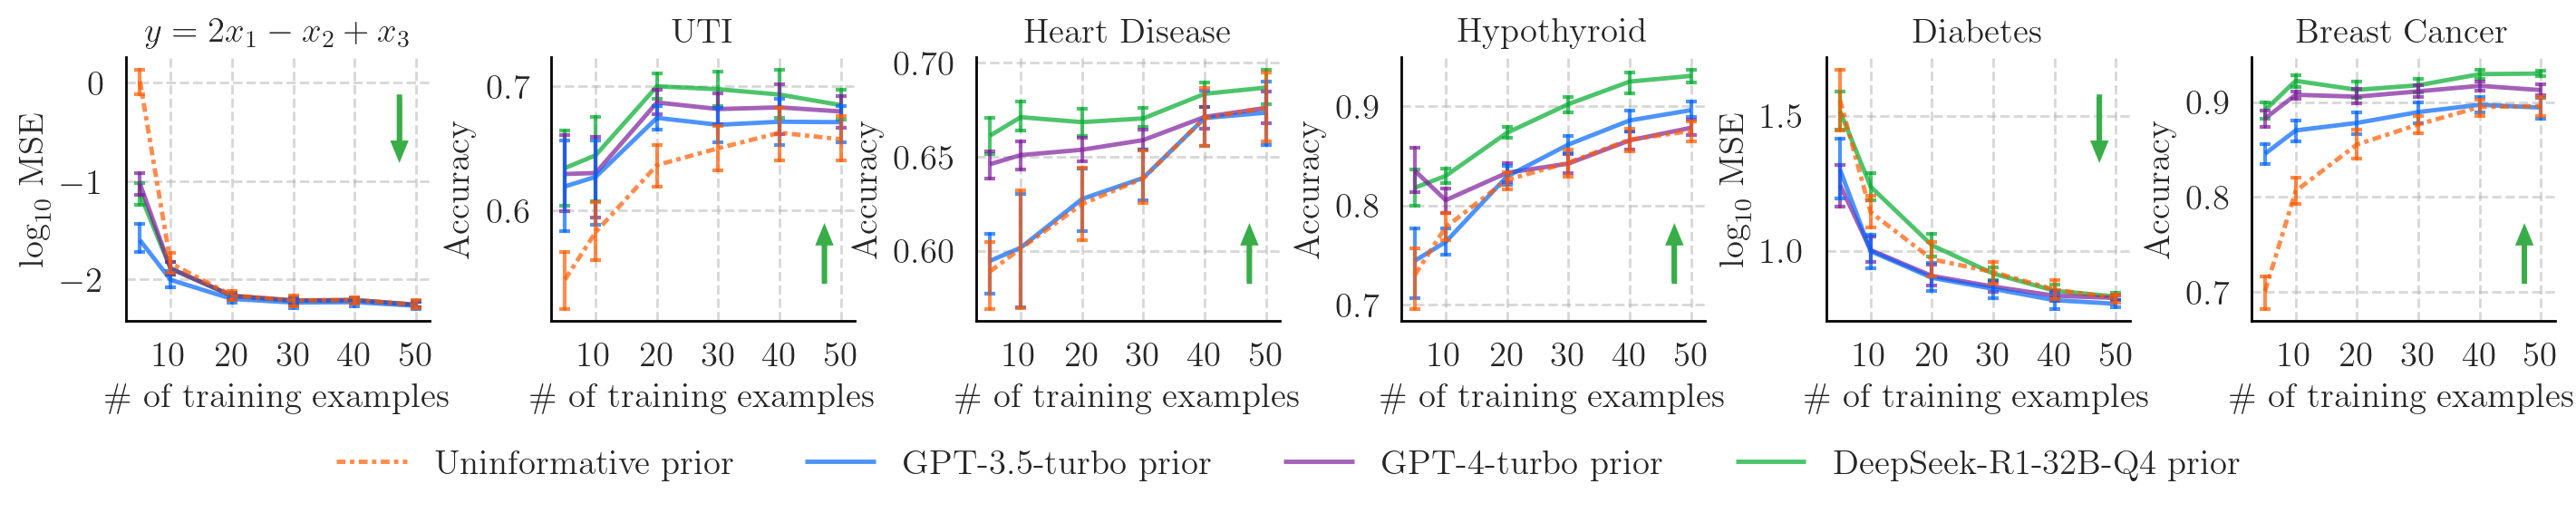

In [20]:
methods_to_plot = [
    "uninformative",
    "informative",
    "gpt_4_turbo_prior",
    "deepseek_32b_q4",
]

fontsize = 14

linewidth_on_plot = 1.75
alpha = 0.7

datasets_to_plot = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Heart Disease",
    "Hypothyroid",
    "Diabetes",
    "Breast Cancer",
    #"California Housing",
    #"Wine Quality",
]

with graph_theme():
    plt.close()

    fig, axes = plt.subplots(
        1, len(datasets_to_plot), 
        figsize=(2*linewidth, 0.6*linewidth/1.618)
    )

    for nax, (dataset, ax) in enumerate(
        zip(
            datasets_to_plot,
            axes
        )
    ):

        ax = sns.lineplot(
            data=(
                pd.concat(
                    [accuracy_results_line_plot, accuracy_results_gpt4]
                )
                .loc[lambda df: df["prior_type"].isin(methods_to_plot)]
                .query("dataset == @dataset")
                .replace({"prior_type": method_names})
                .assign(
                    metrics_to_plot=lambda x: 
                    np.log10(x["metrics_to_plot"].astype(float)) 
                    if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]
                    else x["metrics_to_plot"]
                )
            ),
            x="n_data_points_seen",
            y="metrics_to_plot",
            hue="prior_type",
            palette=palette,
            style="prior_type",
            style_order=[
                method_names[m_name]
                for m_name in methods_to_plot
            ],
            alpha=alpha,
            dashes=dashes,
            err_style="bars",
            errorbar=("ci", 95),
            err_kws=dict(
                capsize=2,
                capthick=1.5,
                elinewidth=1.5,
                linewidth=1.5,
            ),
            markersize=6,
            linewidth=linewidth_on_plot,
            ax=ax,
            legend=False
        )

        if nax == 0:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        else:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        ax.set_xlabel("\# of training examples", fontsize=fontsize)
        ax.tick_params(axis="both", labelsize=fontsize)
        ax.set_title(dataset, fontsize=fontsize)
        ax.set_xticks(np.arange(0, 51, 10))

        y = (
            0.15 
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else 0.85
        )
        dy = (
            0.075*(0.8/0.3)*(1.4/1.6)*5/6
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else -0.075*(0.8/0.3)*(1.4/1.6)
        )
        ax.arrow(
            x=0.9, y=y, 
            dx=0.0, dy=dy,
            head_width=0.05/(1.25*1.33)*6/5, 
            head_length=0.025*(1.25*1.33)*(0.5/0.3)*(1.4/1.6)*5/6,
            color='xkcd:medium green',
            alpha=1.0,
            linewidth=2,
            transform=ax.transAxes
        )


    leg = fig.legend(
        loc="lower center",
        labels=[
            method_names[m_name] for m_name in methods_to_plot
        ], 
        handles=[
            plt.Line2D(
                [0,1], [0,1], 
                color=palette[method_names[m_name]], 
                markerfacecolor=palette[method_names[m_name]], 
                markeredgecolor="white",
                markersize=6,
                linewidth=linewidth_on_plot,
                linestyle=(0, dashes[method_names[m_name]]),
                alpha=alpha,
            )
            for m_name in methods_to_plot
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, -0.05),
        ncols=5,
        frameon=False,
    )

    fig.subplots_adjust(
        wspace=0.4,
        left=0.05,
        right=0.99,
        top=0.9,
        bottom=0.35,
    )

    fig.savefig("results/elicitation_results_lineplot.pdf")
    fig.savefig("results/elicitation_results_lineplot.svg")
    fig.savefig("results/elicitation_results_lineplot.png", dpi=400)


    plt.show()

## What do the priors for the synthetic data look like?

In [21]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [22]:
prior_files = [f for f in os.listdir(PRIORS_DIR.joinpath("gpt-3-5-turbo-0125")) if f.startswith("fake_data")]
priors = []
for prior_file in prior_files:
    prior = np.load(os.path.join(PRIORS_DIR.joinpath("gpt-3-5-turbo-0125"), prior_file))
    priors.append(prior)

priors = np.stack(priors)

In [23]:
# sampling prior parameters

n_priors, n_features, _ = priors.shape
with pm.Model() as model:

    w = pm.Dirichlet(
        'w', a=np.ones(n_priors), shape=(n_features, n_priors)
    )

    components = pm.Normal.dist(
        mu=priors[:, :, 0].T,
        sigma=priors[:, :, 1].T,
        shape=(n_features, n_priors)
    )

    theta = pm.Mixture(
        "theta",
        w=w,
        comp_dists=components,
    )

    prior_samples_pe = pm.sample_prior_predictive(samples=10000)

prior_samples_pe = (
    prior_samples_pe['prior']['theta']
    .to_numpy().squeeze()
)

Sampling: [theta, w]


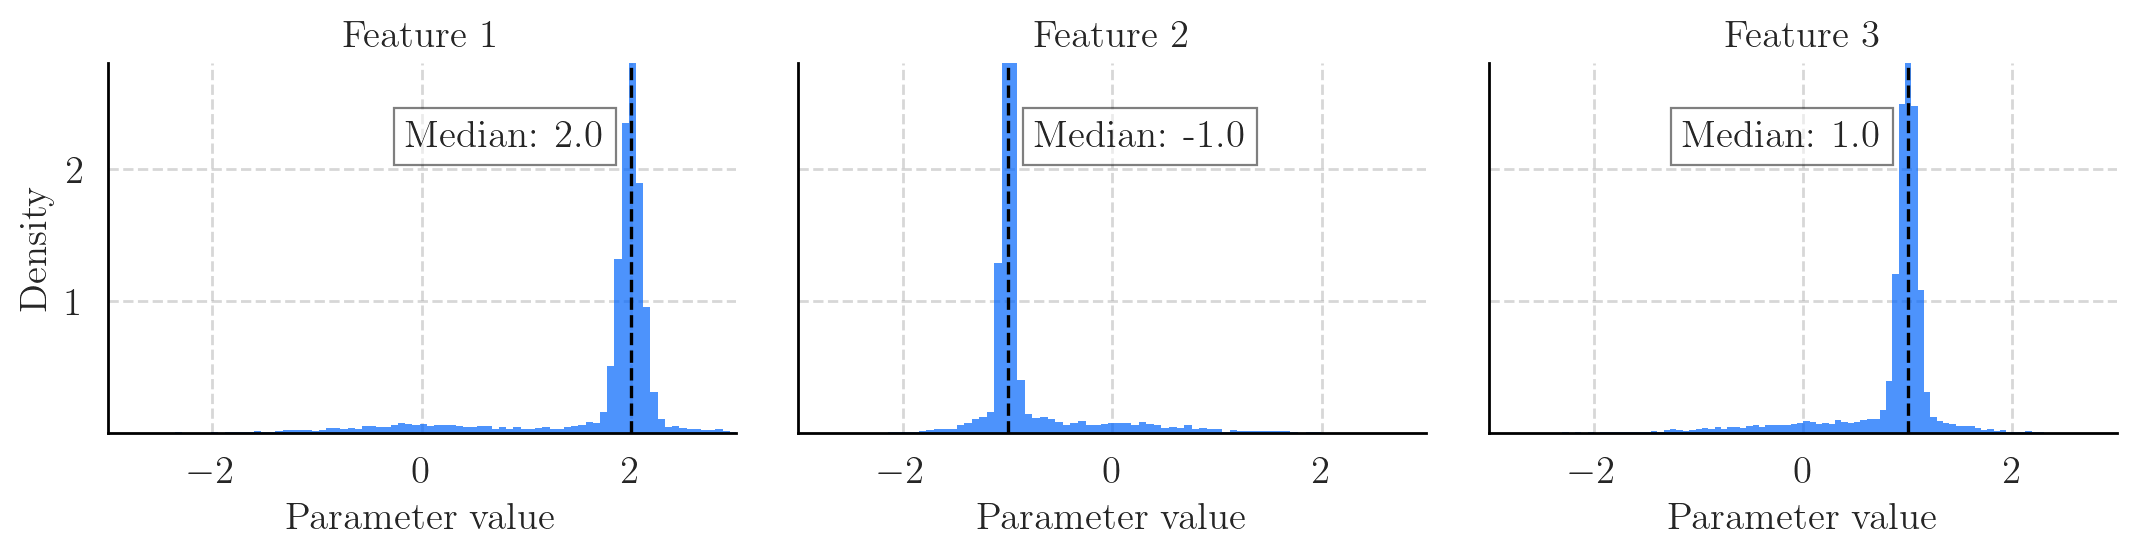

In [24]:
fontsize = 14
alpha = 0.7
hist_config = dict(
    alpha = alpha,
    bins=100,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)

with graph_theme():
    plt.close()

    fig = plt.figure(
        figsize=(1.5*linewidth, 0.3*2*linewidth/1.618)
    )

    for feature in range(n_features-1):
        ax = fig.add_subplot(1, n_features-1, feature+1)

        sns.histplot(
            prior_samples_pe[:, feature + 1], 
            color="xkcd:bright blue",
            ax=ax,
            **hist_config
        )
        ax.set_title(f"Feature {feature + 1}", fontsize=fontsize)
        if feature == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
            ax.set_yticks([1,2,3])
            ax.set_yticklabels([1,2,""])
        else:
            ax.set_ylabel("", fontsize=fontsize)
            ax.set_yticks([1,2,3])
            ax.set_yticklabels([])

        ax.set_xlabel(f"Parameter value", fontsize=fontsize)

        ax.tick_params(axis="both", labelsize=fontsize)

        ax.set_xlim(-3,3)
        ax.set_ylim(0, 2.8)


        median_param_value = np.median(prior_samples_pe[:, feature+1])

        ax.axvline(
            x=median_param_value, 
            linestyle="--", 
            color="xkcd:black",
        )

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

        if median_param_value > 0:
            ax.text(
                median_param_value-0.25, 0.8, 
                f"Median: {median_param_value:.1f}",
                fontsize=fontsize,
                transform=trans,
                verticalalignment='center',
                horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
            )
        else:
            ax.text(
                median_param_value+0.25, 0.8, 
                f"Median: {median_param_value:.1f}",
                fontsize=fontsize,
                transform=trans,
                verticalalignment='center',
                horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
            )


    fig.subplots_adjust(
        wspace=0.1,
        top=0.9,
        bottom=0.2,
        left=0.05,
        right=0.99,
    )

    fig.savefig("results/fake_data_prior_samples_pe.pdf")
    fig.savefig("results/fake_data_prior_samples_pe.png", dpi=300)
    fig.savefig("results/fake_data_prior_samples_pe.svg")

    plt.show()


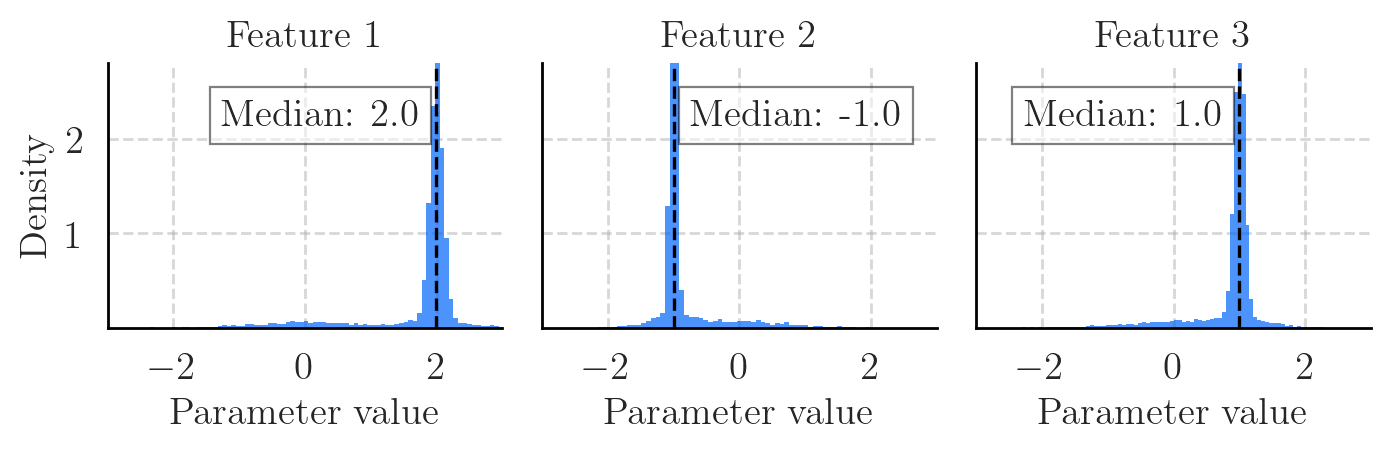

In [25]:
fontsize = 14
alpha = 0.7
hist_config = dict(
    alpha = alpha,
    bins=100,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)

with graph_theme():
    plt.close()

    fig = plt.figure(
        figsize=(2*colwidth, 0.5*2*colwidth/1.618)
    )

    for feature in range(n_features-1):
        ax = fig.add_subplot(1, n_features-1, feature+1)

        sns.histplot(
            prior_samples_pe[:, feature + 1], 
            color="xkcd:bright blue",
            ax=ax,
            **hist_config
        )
        ax.set_title(f"Feature {feature + 1}", fontsize=fontsize)
        if feature == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
            ax.set_yticks([1,2,3])
            ax.set_yticklabels([1,2,""])
        else:
            ax.set_ylabel("", fontsize=fontsize)
            ax.set_yticks([1,2,3])
            ax.set_yticklabels([])

        ax.set_xlabel(f"Parameter value", fontsize=fontsize)

        ax.tick_params(axis="both", labelsize=fontsize)

        ax.set_xlim(-3,3)
        ax.set_ylim(0, 2.8)


        median_param_value = np.median(prior_samples_pe[:, feature+1])

        ax.axvline(
            x=median_param_value, 
            linestyle="--", 
            color="xkcd:black",
        )

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

        if median_param_value > 0:
            ax.text(
                median_param_value-0.25, 0.8, 
                f"Median: {median_param_value:.1f}",
                fontsize=fontsize,
                transform=trans,
                verticalalignment='center',
                horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
            )
        else:
            ax.text(
                median_param_value+0.25, 0.8, 
                f"Median: {median_param_value:.1f}",
                fontsize=fontsize,
                transform=trans,
                verticalalignment='center',
                horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
            )


    fig.subplots_adjust(
        wspace=0.1,
        top=0.875,
        bottom=0.25,
        left=0.07,
        right=0.99,
    )

    fig.savefig("results/fake_data_prior_samples_pe_single_col.pdf")
    fig.savefig("results/fake_data_prior_samples_pe_single_col.png", dpi=300)
    fig.savefig("results/fake_data_prior_samples_pe_single_col.svg")

    plt.show()


## What happens if we provide expert information?

This is tested on the UTI dataset

In [11]:
import pymc as pm
from llm_elicited_priors.datasets import load_uti

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


What happens to the prior distribution:

In [12]:
# sampling prior parameters without expert information

prior_files = [
    f for 
    f in os.listdir(PRIORS_DIR.joinpath("gpt-3-5-turbo-0125")) 
    if f.startswith("uti")
]
priors = []
for prior_file in prior_files:
    prior = np.load(
        os.path.join(PRIORS_DIR.joinpath("gpt-3-5-turbo-0125"), prior_file)
    )
    priors.append(prior)

priors = np.stack(priors)

n_priors, n_features, _ = priors.shape
with pm.Model() as model:

    w = pm.Dirichlet(
        'w', a=np.ones(n_priors), shape=(n_features, n_priors)
    )

    components = pm.Normal.dist(
        mu=priors[:, :, 0].T,
        sigma=priors[:, :, 1].T,
        shape=(n_features, n_priors)
    )

    theta = pm.Mixture(
        "theta",
        w=w,
        comp_dists=components,
    )

    no_expert_prior_samples_pe = pm.sample_prior_predictive(samples=10000)

no_expert_prior_samples_pe = (
    no_expert_prior_samples_pe['prior']['theta']
    .to_numpy().squeeze()
)

Sampling: [theta, w]


In [13]:
# sampling prior parameters with expert information

prior_files = [
    f for 
    f in os.listdir(PRIORS_DIR.joinpath("with_expert_information/gpt-3-5-turbo-0125")) 
    if f.startswith("uti")
]
priors = []
for prior_file in prior_files:
    prior = np.load(
        os.path.join(PRIORS_DIR.joinpath("with_expert_information/gpt-3-5-turbo-0125"), prior_file)
    )
    priors.append(prior)

priors = np.stack(priors)

n_priors, n_features, _ = priors.shape
with pm.Model() as model:

    w = pm.Dirichlet(
        'w', a=np.ones(n_priors), shape=(n_features, n_priors)
    )

    components = pm.Normal.dist(
        mu=priors[:, :, 0].T,
        sigma=priors[:, :, 1].T,
        shape=(n_features, n_priors)
    )

    theta = pm.Mixture(
        "theta",
        w=w,
        comp_dists=components,
    )

    expert_prior_samples_pe = pm.sample_prior_predictive(samples=10000)

expert_prior_samples_pe = (
    expert_prior_samples_pe['prior']['theta']
    .to_numpy().squeeze()
)

Sampling: [theta, w]


In [14]:
with pm.Model() as model:

    theta = pm.Normal(
        "theta",
        mu=0 * np.ones(n_features),
        sigma=1 * np.ones(n_features),
        shape=(n_features)
    )

    uninformative_prior_samples_pe = pm.sample_prior_predictive(samples=10000)

uninformative_prior_samples_pe = (
    uninformative_prior_samples_pe['prior']['theta']
    .to_numpy().squeeze()
)

Sampling: [theta]


In [15]:
features_given_information_for = [
    'bathroom frequency',
    'night time awake frequency',
    'number of previous urinary tract infections',
]

uti_features = load_uti().feature_names.tolist()

features_given_information_for_idx = np.array([
    uti_features.index(f) for f in features_given_information_for
])
print(features_given_information_for_idx)

[0 2 9]


What happens to the posterior accuracy:

In [16]:
results_df = results_df.query("dataset == 'uti'")

In [17]:
# results directory for each model
model_results_dir_dict = {
    "informative": "with_expert_information/gpt-3-5-turbo-0125",
}

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    # loading the results from the dictionaries to a dataframe
    model_results_df = (
        result_dicts_to_df(
            # loading the files to dictionaries
            *load_result_dicts(RESULTS_PATH.joinpath(model_results_dir))
        )
    ).replace(
        {
            "prior_type": {
                "informative": "with_expert_information",
            }
        }
    )

    results_df = pd.concat(
        [
            results_df,
            model_results_df
        ]
    )

Loading results:   0%|          | 0/1 [00:00<?, ?it/s]

Loading 10 files from results/elicitation/with_expert_information/gpt-3-5-turbo-0125


Loading results: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


In [18]:
model_results_df

,dataset,run,n_data_points_seen,prior_type,accuracy,average_accuracy,average_auc,results_file_name
0,uti,9,2,with_expert_information,"[[0.42487046632124353, 0.5129533678756477, 0.4...",0.527344,0.660310,prior_no_prior_results_uti_9.json
0,uti,9,5,with_expert_information,"[[0.7150259067357513, 0.533678756476684, 0.740...",0.663308,0.774394,prior_no_prior_results_uti_9.json
0,uti,9,10,with_expert_information,"[[0.6632124352331606, 0.694300518134715, 0.720...",0.677207,0.733356,prior_no_prior_results_uti_9.json
0,uti,9,20,with_expert_information,"[[0.7253886010362695, 0.7098445595854922, 0.73...",0.694276,0.766038,prior_no_prior_results_uti_9.json
0,uti,9,30,with_expert_information,"[[0.6269430051813472, 0.6994818652849741, 0.66...",0.701121,0.773585,prior_no_prior_results_uti_9.json
...,...,...,...,...,...,...,...,...
0,uti,6,10,with_expert_information,"[[0.6481481481481481, 0.6790123456790124, 0.63...",0.639762,0.703034,prior_no_prior_results_uti_6.json
0,uti,6,20,with_expert_information,"[[0.6666666666666666, 0.6790123456790124, 0.70...",0.664462,0.735563,prior_no_prior_results_uti_6.json
0,uti,6,30,with_expert_information,"[[0.6296296296296297, 0.7037037037037037, 0.66...",0.666697,0.732822,prior_no_prior_results_uti_6.json
0,uti,6,40,with_expert_information,"[[0.6604938271604939, 0.6481481481481481, 0.69...",0.661620,0.722770,prior_no_prior_results_uti_6.json


In [19]:
dataset_metric_to_plot = {
    "uti": "accuracy",
}
dataset_rename = {
    "uti": "UTI",
}

accuracy_results = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .assign(sample=lambda x: x["metrics_to_plot"].apply(lambda x: np.arange(len(x))))
    .explode(["metrics_to_plot", "sample"])
    .set_index("sample", append=True)
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
)

In [20]:
accuracy_results_line_plot = (
    accuracy_results
    .loc[lambda df: df["n_data_points_seen"].isin([5, 10, 20, 25, 30, 40, 50])]
    .groupby(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .mean()
    .reset_index()
)

In [21]:
accuracy_results_line_plot.loc[
    lambda df: df["prior_type"]
    .isin(["uninformative", "informative", "with_expert_information"])
].reset_index()

,index,dataset,n_data_points_seen,prior_type,run,metrics_to_plot
0,20,UTI,5,informative,0,0.734874
1,21,UTI,5,informative,1,0.541828
2,22,UTI,5,informative,2,0.57939
3,23,UTI,5,informative,3,0.701877
4,24,UTI,5,informative,4,0.530245
...,...,...,...,...,...,...
175,295,UTI,50,with_expert_information,5,0.687704
176,296,UTI,50,with_expert_information,6,0.687744
177,297,UTI,50,with_expert_information,7,0.660589
178,298,UTI,50,with_expert_information,8,0.627949


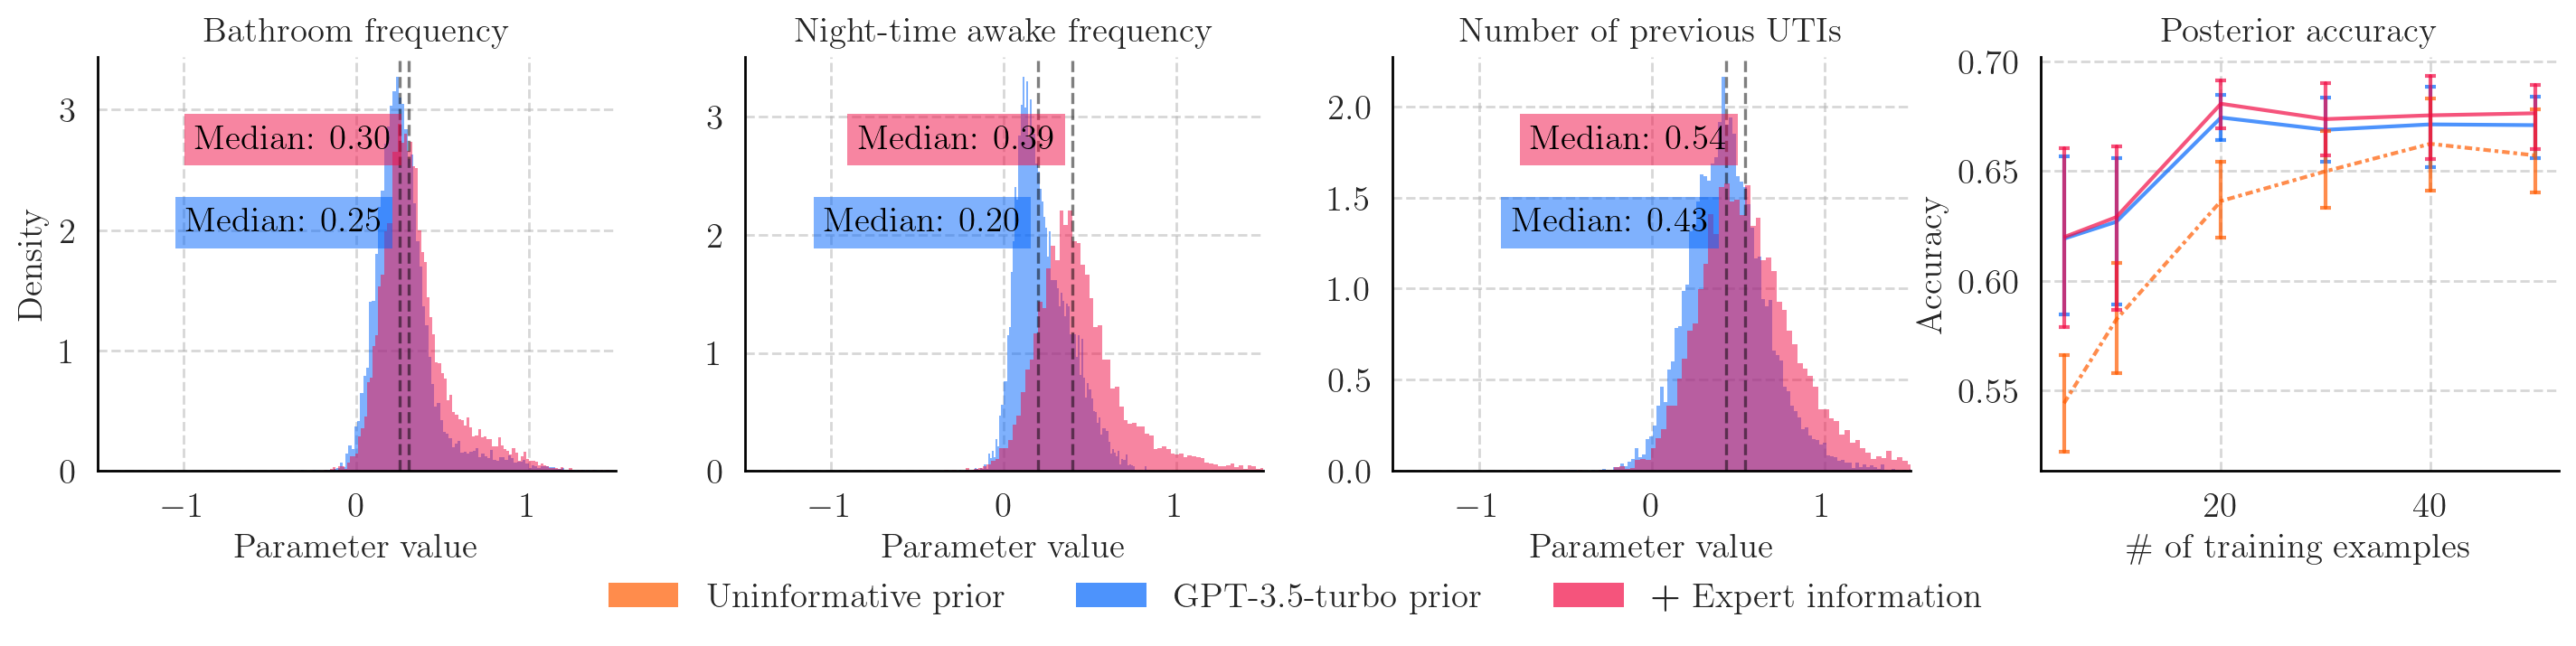

In [27]:
fontsize = 14
alpha = 0.5
hist_config = dict(
    alpha = alpha,
    bins=100,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)

method_names = {
    "uninformative": "Uninformative prior", 
    "informative": "Mixture of elicited Gaussian priors",
    "with_expert_information": "+ expert information",
}

feature_nice_names = {
    'bathroom frequency': "Bathroom frequency",
    'night time awake frequency': "Night-time awake frequency",
    'number of previous urinary tract infections': "Number of previous UTIs",
    
}

with graph_theme():
    plt.close()

    fig = plt.figure(
        figsize=(2*linewidth, 0.4*2*linewidth/1.618)
    )

    for nax, feature in enumerate(
        features_given_information_for_idx + 1
    ): # adding one because of the intercept
        ax = fig.add_subplot(1, len(features_given_information_for)+1, nax+1)

        sns.histplot(
            no_expert_prior_samples_pe[:, feature], 
            color="xkcd:bright blue",
            ax=ax,
            **hist_config
        )
        sns.histplot(
            expert_prior_samples_pe[:, feature], 
            color="xkcd:pinkish red",
            ax=ax,
            **hist_config
        )
        ax.set_title(f"{feature_nice_names[features_given_information_for[nax]]}", fontsize=fontsize)
        if nax == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
        else:
            ax.set_ylabel("", fontsize=fontsize)

        ax.set_xlabel(f"Parameter value", fontsize=fontsize)

        ax.tick_params(axis="both", labelsize=fontsize)

        ax.set_xlim(-1.5, 1.5)

        # non expert median
        median_param_value = np.median(no_expert_prior_samples_pe[:, feature])

        ax.axvline(
            x=median_param_value, 
            linestyle="--", 
            color="xkcd:black",
            alpha=0.5,
        )

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        if median_param_value > 0:
            ax.text(
                median_param_value-0.1, 0.6, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='right',
                bbox=dict(facecolor='xkcd:bright blue', alpha=0.5, edgecolor='none'),
            )
        else:
            ax.text(
                median_param_value+0.1, 0.6, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='left',
                bbox=dict(facecolor='xkcd:bright blue', alpha=0.25, edgecolor='none'),
            )

        # expert median

        median_param_value = np.median(expert_prior_samples_pe[:, feature])

        ax.axvline(
            x=median_param_value, 
            linestyle="--", 
            color="xkcd:black",
            alpha=0.5,
        )

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        if median_param_value > 0:
            ax.text(
                median_param_value-0.1, 0.8, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='right',
                bbox=dict(facecolor='xkcd:pinkish red', alpha=0.5, edgecolor='none'),
            )
        else:
            ax.text(
                median_param_value+0.1, 0.8, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='left',
                bbox=dict(facecolor='xkcd:pinkish red', alpha=0.25, edgecolor='none'),
            )


    ax = fig.add_subplot(1, len(features_given_information_for)+1, len(features_given_information_for)+1)
    ax = sns.lineplot(
        data=(
            accuracy_results_line_plot
            .loc[
                lambda df: df["prior_type"]
                .isin(["uninformative", "informative", "with_expert_information"])
            ]
            .reset_index()
            .replace(
                {
                    "prior_type": method_names
                }
            )),
        x="n_data_points_seen",
        y="metrics_to_plot",
        hue="prior_type",
        palette={
            method_names["uninformative"]:"xkcd:bright orange", 
            method_names["informative"]:"xkcd:bright blue",
            method_names["with_expert_information"]:"xkcd:pinkish red"
        },
        style="prior_type",
        style_order=[method_names["informative"], method_names["uninformative"], method_names["with_expert_information"]],
        alpha=0.7,
        dashes={
            method_names["uninformative"]: (2, 1, 1, 1),
            method_names["informative"]: (1, 0), 
            method_names["with_expert_information"]: (1, 0), 
        },
        err_style="bars",
        errorbar=("ci", 95),
        err_kws=dict(
            capsize=2,
            capthick=1.5,
            elinewidth=1.5,
            linewidth=1.5,
        ),
        markersize=6,
        linewidth=1.5,
        ax=ax,
        legend=False
    )

    if nax == 0:
        ax.set_ylabel("Accuracy", fontsize=fontsize)
    else:
        ax.set_ylabel("Accuracy", fontsize=fontsize)
    ax.set_xlabel("\# of training examples", fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.set_title("Posterior accuracy", fontsize=fontsize)


    fig.legend(
        loc="center",
        labels=[
            "Uninformative prior",
            "GPT-3.5-turbo prior",
            r"\textbf{+} Expert information",
        ],
        handles=[
            mpatches.Patch(
                facecolor="xkcd:bright orange", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:bright blue", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:pinkish red", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.05),
        ncols=3,
        frameon=False
    )

    fig.subplots_adjust(
        wspace=0.25,
        top=0.9,
        bottom=0.25,
        left=0.035,
        right=0.99,
    )

    fig.savefig("results/uti_with_expert_information.pdf")
    fig.savefig("results/uti_with_expert_information.png", dpi=300)

    plt.show()


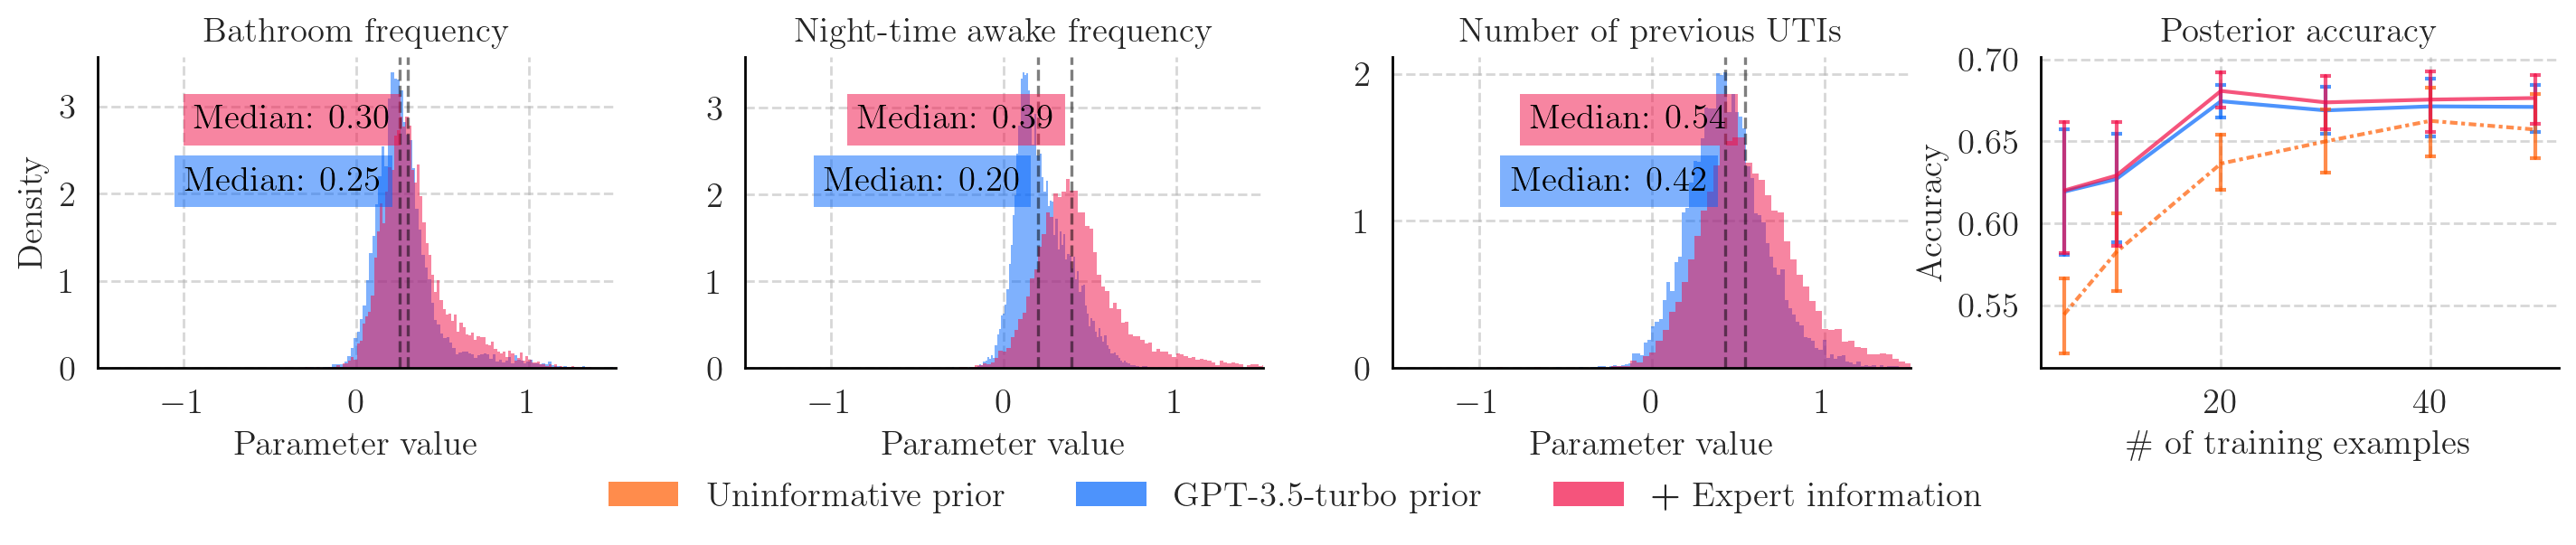

In [ ]:
fontsize = 14
alpha = 0.5
hist_config = dict(
    alpha = alpha,
    bins=100,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)

method_names = {
    "uninformative": "Uninformative prior", 
    "informative": "Mixture of elicited Gaussian priors",
    "with_expert_information": "+ expert information",
}

feature_nice_names = {
    'bathroom frequency': "Bathroom frequency",
    'night time awake frequency': "Night-time awake frequency",
    'number of previous urinary tract infections': "Number of previous UTIs",
    
}

with graph_theme():
    plt.close()

    fig = plt.figure(
        figsize=(2*linewidth, 0.325*2*linewidth/1.618)
    )

    for nax, feature in enumerate(
        features_given_information_for_idx + 1
    ): # adding one because of the intercept
        ax = fig.add_subplot(1, len(features_given_information_for)+1, nax+1)

        sns.histplot(
            no_expert_prior_samples_pe[:, feature], 
            color="xkcd:bright blue",
            ax=ax,
            **hist_config
        )
        sns.histplot(
            expert_prior_samples_pe[:, feature], 
            color="xkcd:pinkish red",
            ax=ax,
            **hist_config
        )
        ax.set_title(f"{feature_nice_names[features_given_information_for[nax]]}", fontsize=fontsize)
        if nax == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
        else:
            ax.set_ylabel("", fontsize=fontsize)

        ax.set_xlabel(f"Parameter value", fontsize=fontsize)

        ax.tick_params(axis="both", labelsize=fontsize)

        ax.set_xlim(-1.5, 1.5)

        # non expert median
        median_param_value = np.median(no_expert_prior_samples_pe[:, feature])

        ax.axvline(
            x=median_param_value, 
            linestyle="--", 
            color="xkcd:black",
            alpha=0.5,
        )

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        if median_param_value > 0:
            ax.text(
                median_param_value-0.1, 0.6, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='right',
                bbox=dict(facecolor='xkcd:bright blue', alpha=0.5, edgecolor='none'),
            )
        else:
            ax.text(
                median_param_value+0.1, 0.6, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='left',
                bbox=dict(facecolor='xkcd:bright blue', alpha=0.25, edgecolor='none'),
            )

        # expert median

        median_param_value = np.median(expert_prior_samples_pe[:, feature])

        ax.axvline(
            x=median_param_value, 
            linestyle="--", 
            color="xkcd:black",
            alpha=0.5,
        )

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        if median_param_value > 0:
            ax.text(
                median_param_value-0.1, 0.8, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='right',
                bbox=dict(facecolor='xkcd:pinkish red', alpha=0.5, edgecolor='none'),
            )
        else:
            ax.text(
                median_param_value+0.1, 0.8, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='left',
                bbox=dict(facecolor='xkcd:pinkish red', alpha=0.25, edgecolor='none'),
            )


    ax = fig.add_subplot(1, len(features_given_information_for)+1, len(features_given_information_for)+1)
    ax = sns.lineplot(
        data=(
            accuracy_results_line_plot
            .loc[
                lambda df: df["prior_type"]
                .isin(["uninformative", "informative", "with_expert_information"])
            ]
            .reset_index()
            .replace(
                {
                    "prior_type": method_names
                }
            )),
        x="n_data_points_seen",
        y="metrics_to_plot",
        hue="prior_type",
        palette={
            method_names["uninformative"]:"xkcd:bright orange", 
            method_names["informative"]:"xkcd:bright blue",
            method_names["with_expert_information"]:"xkcd:pinkish red"
        },
        style="prior_type",
        style_order=[method_names["informative"], method_names["uninformative"], method_names["with_expert_information"]],
        alpha=0.7,
        dashes={
            method_names["uninformative"]: (2, 1, 1, 1),
            method_names["informative"]: (1, 0), 
            method_names["with_expert_information"]: (1, 0), 
        },
        err_style="bars",
        errorbar=("ci", 95),
        err_kws=dict(
            capsize=2,
            capthick=1.5,
            elinewidth=1.5,
            linewidth=1.5,
        ),
        markersize=6,
        linewidth=1.5,
        ax=ax,
        legend=False
    )

    if nax == 0:
        ax.set_ylabel("Accuracy", fontsize=fontsize)
    else:
        ax.set_ylabel("Accuracy", fontsize=fontsize)
    ax.set_xlabel("\# of training examples", fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.set_title("Posterior accuracy", fontsize=fontsize)


    fig.legend(
        loc="center",
        labels=[
            "Uninformative prior",
            "GPT-3.5-turbo prior",
            r"\textbf{+} Expert information",
        ],
        handles=[
            mpatches.Patch(
                facecolor="xkcd:bright orange", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:bright blue", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:pinkish red", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.05),
        ncols=3,
        frameon=False
    )

    fig.subplots_adjust(
        wspace=0.25,
        top=0.9,
        bottom=0.3,
        left=0.035,
        right=0.99,
    )

    fig.savefig("results/uti_with_expert_information_mid.pdf")
    fig.savefig("results/uti_with_expert_information_mid.png", dpi=300)

    plt.show()


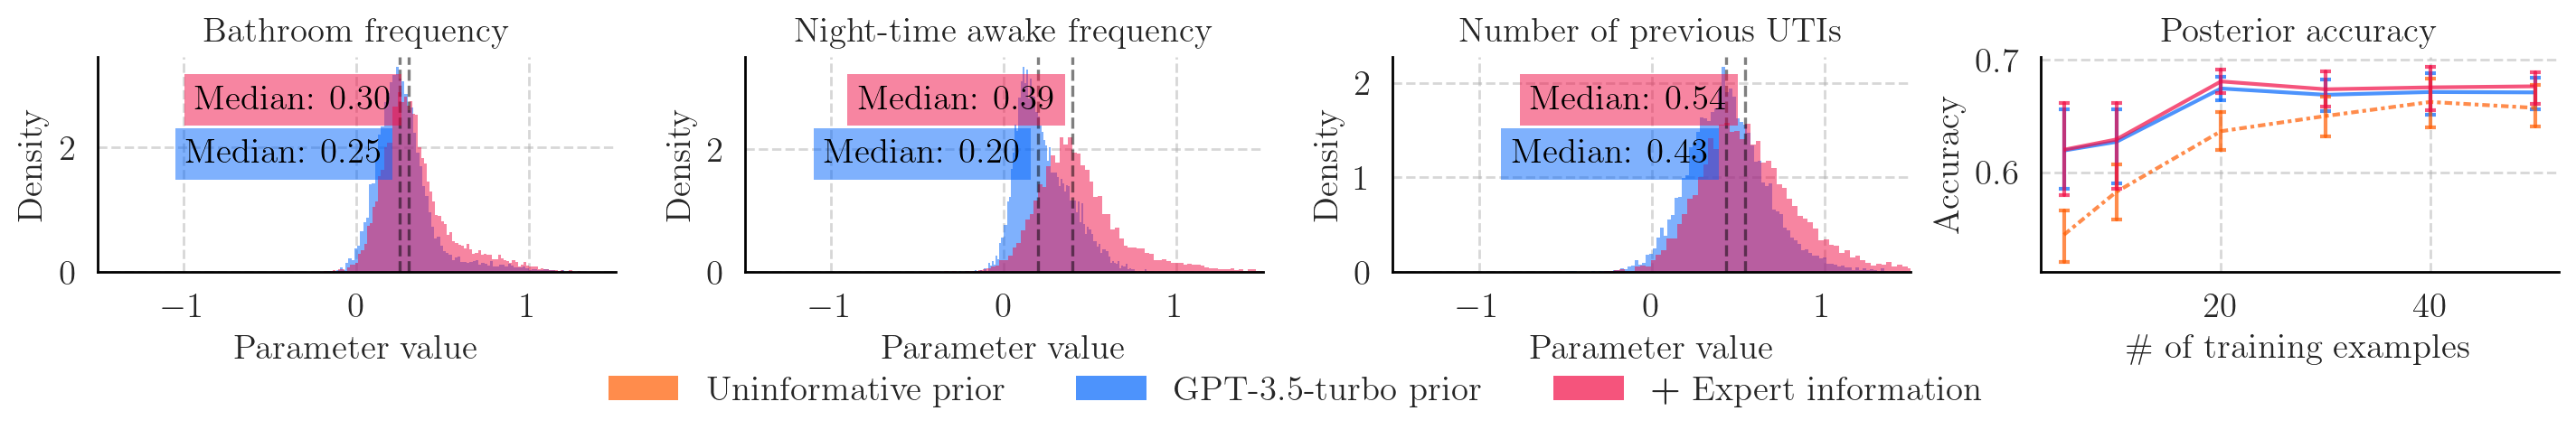

In [28]:
fontsize = 14
alpha = 0.5
hist_config = dict(
    alpha = alpha,
    bins=100,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)

method_names = {
    "uninformative": "Uninformative prior", 
    "informative": "Mixture of elicited Gaussian priors",
    "with_expert_information": "+ expert information",
}

feature_nice_names = {
    'bathroom frequency': "Bathroom frequency",
    'night time awake frequency': "Night-time awake frequency",
    'number of previous urinary tract infections': "Number of previous UTIs",
    
}

with graph_theme():
    plt.close()

    fig = plt.figure(
        figsize=(2*linewidth, 0.25*2*linewidth/1.618)
    )

    for nax, feature in enumerate(
        features_given_information_for_idx + 1
    ): # adding one because of the intercept
        ax = fig.add_subplot(1, len(features_given_information_for)+1, nax+1)

        sns.histplot(
            no_expert_prior_samples_pe[:, feature], 
            color="xkcd:bright blue",
            ax=ax,
            **hist_config
        )
        sns.histplot(
            expert_prior_samples_pe[:, feature], 
            color="xkcd:pinkish red",
            ax=ax,
            **hist_config
        )
        ax.set_title(f"{feature_nice_names[features_given_information_for[nax]]}", fontsize=fontsize)
        if nax == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
        else:
            ax.set_ylabel("Density", fontsize=fontsize)

        ax.set_xlabel(f"Parameter value", fontsize=fontsize)

        ax.tick_params(axis="both", labelsize=fontsize)

        ax.set_xlim(-1.5, 1.5)

        # non expert median
        median_param_value = np.median(no_expert_prior_samples_pe[:, feature])

        ax.axvline(
            x=median_param_value, 
            linestyle="--", 
            color="xkcd:black",
            alpha=0.5,
        )

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        if median_param_value > 0:
            ax.text(
                median_param_value-0.1, 0.55, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='right',
                bbox=dict(facecolor='xkcd:bright blue', alpha=0.5, edgecolor='none'),
            )
        else:
            ax.text(
                median_param_value+0.1, 0.55, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='left',
                bbox=dict(facecolor='xkcd:bright blue', alpha=0.25, edgecolor='none'),
            )

        # expert median

        median_param_value = np.median(expert_prior_samples_pe[:, feature])

        ax.axvline(
            x=median_param_value, 
            linestyle="--", 
            color="xkcd:black",
            alpha=0.5,
        )

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        if median_param_value > 0:
            ax.text(
                median_param_value-0.1, 0.8, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='right',
                bbox=dict(facecolor='xkcd:pinkish red', alpha=0.5, edgecolor='none'),
            )
        else:
            ax.text(
                median_param_value+0.1, 0.8, 
                f"Median: {median_param_value:.2f}",
                fontsize=fontsize,
                transform=trans,
                color="black",
                verticalalignment='center',
                horizontalalignment='left',
                bbox=dict(facecolor='xkcd:pinkish red', alpha=0.25, edgecolor='none'),
            )


    ax = fig.add_subplot(1, len(features_given_information_for)+1, len(features_given_information_for)+1)
    ax = sns.lineplot(
        data=(
            accuracy_results_line_plot
            .loc[
                lambda df: df["prior_type"]
                .isin(["uninformative", "informative", "with_expert_information"])
            ]
            .reset_index()
            .replace(
                {
                    "prior_type": method_names
                }
            )),
        x="n_data_points_seen",
        y="metrics_to_plot",
        hue="prior_type",
        palette={
            method_names["uninformative"]:"xkcd:bright orange", 
            method_names["informative"]:"xkcd:bright blue",
            method_names["with_expert_information"]:"xkcd:pinkish red"
        },
        style="prior_type",
        style_order=[method_names["informative"], method_names["uninformative"], method_names["with_expert_information"]],
        alpha=0.7,
        dashes={
            method_names["uninformative"]: (2, 1, 1, 1),
            method_names["informative"]: (1, 0), 
            method_names["with_expert_information"]: (1, 0), 
        },
        err_style="bars",
        errorbar=("ci", 95),
        err_kws=dict(
            capsize=2,
            capthick=1.5,
            elinewidth=1.5,
            linewidth=1.5,
        ),
        markersize=6,
        linewidth=1.5,
        ax=ax,
        legend=False
    )

    if nax == 0:
        ax.set_ylabel("Accuracy", fontsize=fontsize)
    else:
        ax.set_ylabel("Accuracy", fontsize=fontsize)
    ax.set_xlabel("\# of training examples", fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.set_title("Posterior accuracy", fontsize=fontsize)


    fig.legend(
        loc="center",
        labels=[
            "Uninformative prior",
            "GPT-3.5-turbo prior",
            r"\textbf{+} Expert information",
        ],
        handles=[
            mpatches.Patch(
                facecolor="xkcd:bright orange", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:bright blue", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
            mpatches.Patch(
                facecolor="xkcd:pinkish red", 
                linewidth=0.0, edgecolor="black", alpha=0.7
            ),
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.05),
        ncols=3,
        frameon=False
    )

    fig.subplots_adjust(
        wspace=0.25,
        top=0.89,
        bottom=0.35,
        left=0.035,
        right=0.99,
    )

    fig.savefig("results/uti_with_expert_information_shorter.pdf")
    fig.savefig("results/uti_with_expert_information_shorter.png", dpi=300)

    plt.show()
